In [1]:
import model_mobster_mv as model_mobster_mv
import numpy as np
import pandas as pd
import pyro.distributions as dist
from scipy import stats

import torch
import seaborn as sns
from scipy.integrate import simpson

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics.cluster import normalized_mutual_info_score

from utils.plot_functions import *
from utils.BoundedPareto import BoundedPareto
from utils.create_beta_pareto_dataset import *

%load_ext autoreload
%autoreload 2

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def log_sum_exp(args):
    if len(args.shape) == 1:
        args = args.unsqueeze(0)
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

def beta_lk(NV, DP, a_beta, b_beta):
    return dist.BetaBinomial(a_beta, b_beta, total_count=DP).log_prob(NV) # simply does log(density)

def pareto_lk(mb, NV, DP, alpha):
    LINSPACE = 8000
    x = torch.linspace(mb.pareto_L, mb.pareto_H, LINSPACE)
    y_1 = BoundedPareto(mb.pareto_L, alpha, mb.pareto_H).log_prob(x).exp()
    y_2 = dist.Binomial(probs = x.repeat([NV.shape[0],1]).reshape([LINSPACE,-1]), total_count=DP).log_prob(NV).exp()
    paretobin = torch.trapz(y_1.reshape([LINSPACE, 1]) * y_2, x =  x, dim = 0).log()
    # 1. pareto = simpson((y_1.reshape([LINSPACE, 1]) * y_2).numpy(), x=x.numpy(), axis=0)
    # 1. pareto = torch.tensor(pareto).log()
    # 2. p = BoundedPareto(0.01, alpha, 0.55).sample()
    # 2. paretobin = dist.Binomial(probs=p, total_count=DP).log_prob(data)
    return paretobin # N x D (if D = 1, only N)

def compute_likelihood(mb, beta = True, dim = 0, k = 0):
    """
    Function to compute the likelihood of the data in a single given dimension.
    """
    NV = mb.NV[:, dim]
    DP = mb.DP[:, dim]
    if beta == True:
        phi_beta = mb.params["phi_beta_param"][k, dim]
        k_beta = mb.params["k_beta_param"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        # return log_sum_exp(beta_lk(NV, DP, a_beta, b_beta)).sum()
        return beta_lk(NV, DP, a_beta, b_beta).sum()
    else:
        alpha = mb.params["alpha_pareto_param"][k, dim] * mb.alpha_factor
        # return log_sum_exp(pareto_lk(mb, NV, DP, alpha)).sum()
        return pareto_lk(mb, NV, DP, alpha).sum()

def compute_likelihood2(mb, NV, DP, beta = True, idx_data = 0, dim = 0, k = 0):
    """
    Function to compute the likelihood of a specific indexed data in a single given dimension.
    """
    NV = NV[:, dim]
    DP = DP[:, dim]
    if beta == True:
        phi_beta = mb.params["phi_beta_param"][k, dim]
        k_beta = mb.params["k_beta_param"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        return beta_lk(NV, DP, a_beta, b_beta)[idx_data] # only take the log-likelihood for a specific datapoint
    else:
        alpha = mb.params["alpha_pareto_param"][k, dim] * mb.alpha_factor
        return pareto_lk(mb, NV, DP, alpha)[idx_data]

def sum_pareto_bin(mb, NV, DP, idx_data = 0, k = 0):
    delta = mb.params["delta_param"][k, :, :] # K x D x 2
    dim = 0
    delta_pareto_0 = delta[dim, 0] + torch.exp(compute_likelihood2(mb, NV, DP, beta = False, idx_data=idx_data, dim=dim, k=k))
    delta_beta_0 = delta[dim, 1] + torch.exp(compute_likelihood2(mb, NV, DP, beta = True, idx_data=idx_data, dim=dim, k=k))
    dim_0 = torch.log(delta_pareto_0+delta_beta_0)
    dim = 1
    delta_pareto_1 = delta[dim, 0] + torch.exp(compute_likelihood2(mb, NV, DP, beta = False, idx_data=idx_data, dim=dim, k=k))
    delta_beta_1 = delta[dim, 1] + torch.exp(compute_likelihood2(mb, NV, DP, beta = True, idx_data=idx_data, dim=dim, k=k))
    print("delta_pareto_1", delta_pareto_1)
    print("delta_beta_1", delta_beta_1)
    dim_1 = torch.log(delta_pareto_1+delta_beta_1)
    return dim_0 + dim_1


### One beta component

Trying to understand if the problem is the $\delta$ or the parameter convergence:
- if one dim of the cluster is assigned to the pareto but the likelihood of beta is higher, then the $\delta$ is wrong
- if one dim of the cluster is assigned to the pareto and the likelihood of pareto is higher, then the parameter convergence is wrong

In [3]:
N1 = 1000
seed = 123
# Component 1
phi_beta_x = 0.1
k_beta_x = 250
phi_beta_y = 0.1
k_beta_y= 250
n1=150
NV, DP = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n1, N=N1, seed=seed)
# 
print(DP.shape)

torch.Size([1000, 2])


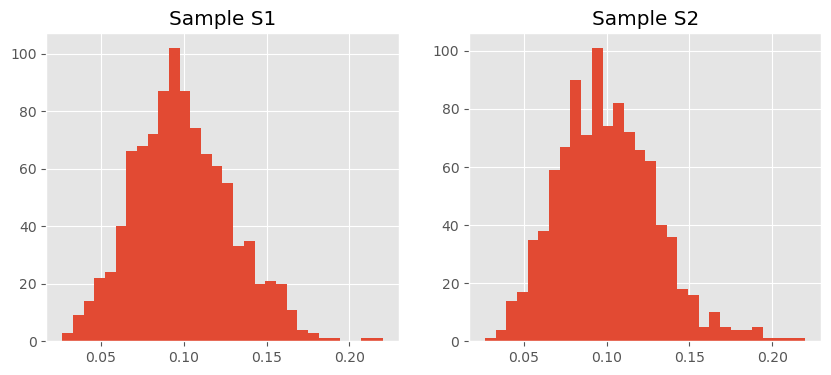

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 30)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 30)
axes[1].set_title("Sample S2")
plt.show()

In [6]:
labels = np.zeros(N1)

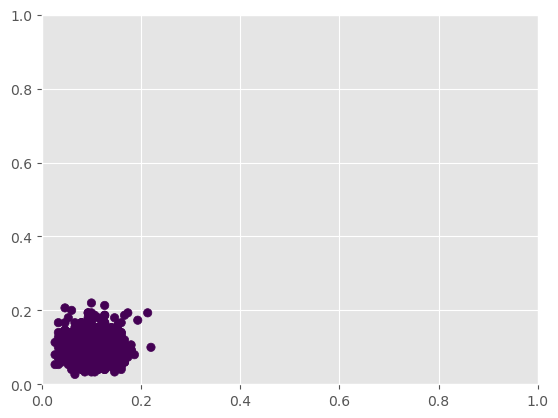

In [7]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K =  1
Beta:  tensor([[1.9799, 2.4966]])
Pareto:  tensor([[0.0275, 0.0112]])
Iteration 0: Loss = 7359090.0
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0007, 0.9992]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.1369, 0.0909]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 99.8029, 100.2002]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3991, 0.6009],
         [0.3990, 0.6010]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 6722368.0
Iteration 400: Loss = 6449889.0
Iteration 600: Loss = 6362800.5
Iteration 800: Loss = 6270118.0
Iteration 1000: Loss = 6074684.5
Iteration 1200: Loss = 6163164.5
Iteration 1400: Loss = 6125886.0
Iteration 1600: Loss = 6072793.5
Iteration 1800: Loss = 6062221.5
Iteration 2000: Loss = 6040803.0
Iteration 2200: Loss = 6021837.5
Iteration 2400: Loss = 6019796.5
Iteration 2600: Loss = 5933051.0
Iteration 2800: Loss = 6000526.0
Iteration 2999: Loss = 5958357.0
phi_beta [[0.10015611 0.10092009]]


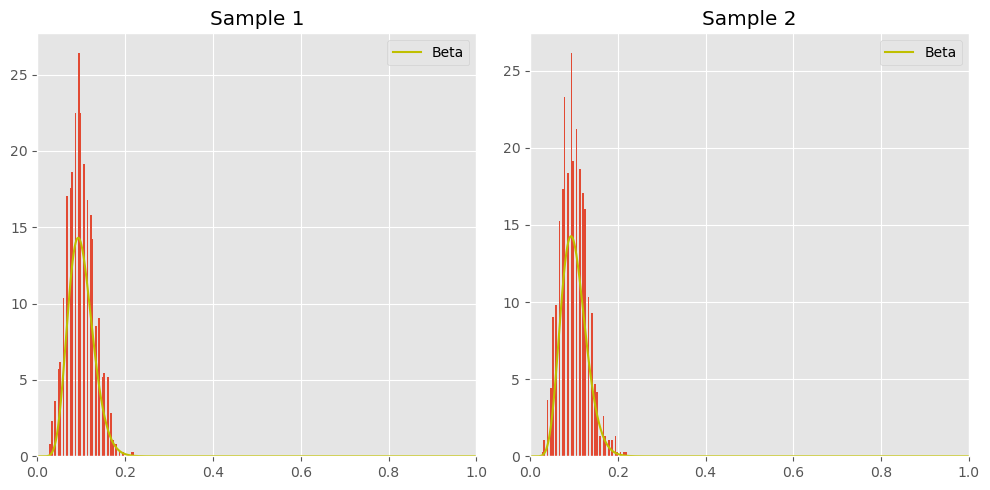

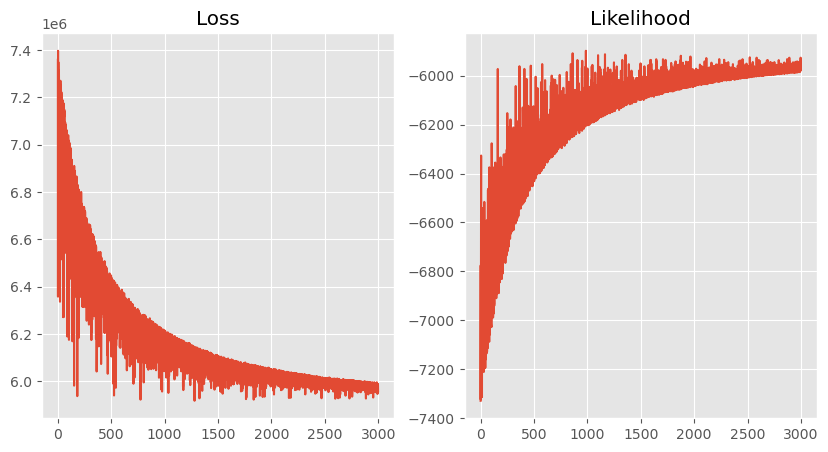

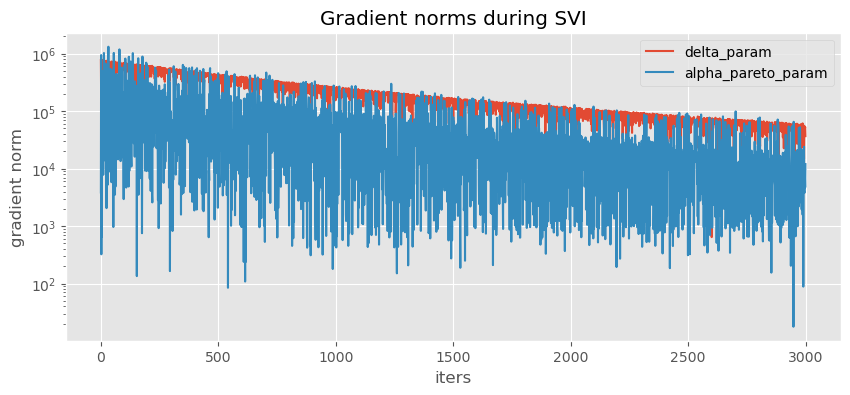

bic:  tensor(25829.3047, grad_fn=<RsubBackward1>)


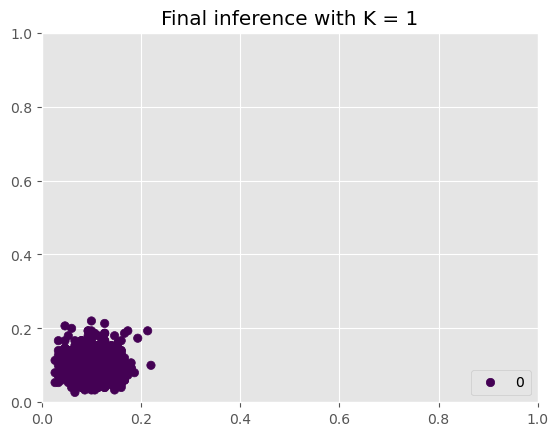

Selected number of clusters is:  1


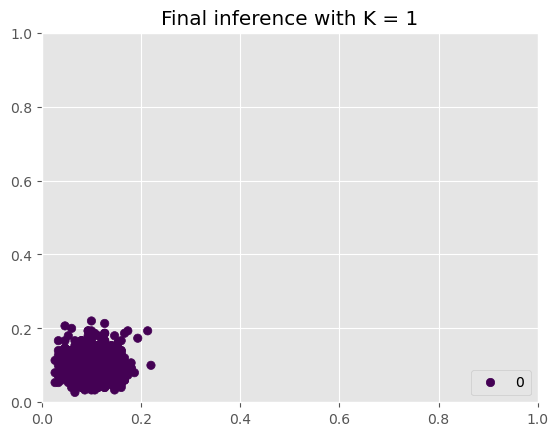

In [9]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [1], seed = 53, lr = 0.001)

In [10]:
print(compute_likelihood(final_mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(final_mb, beta = False, dim = 0, k = 0))

print(compute_likelihood(final_mb, beta = True, dim = 1, k = 0))
print(compute_likelihood(final_mb, beta = False, dim = 1, k = 0))

tensor(-2964.3940, grad_fn=<SumBackward0>)
tensor(-4440.6348, grad_fn=<SumBackward0>)
tensor(-2960.4233, grad_fn=<SumBackward0>)
tensor(-4433.6860, grad_fn=<SumBackward0>)


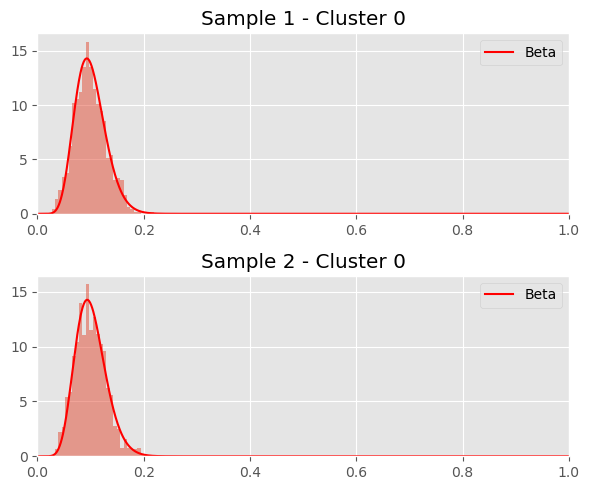

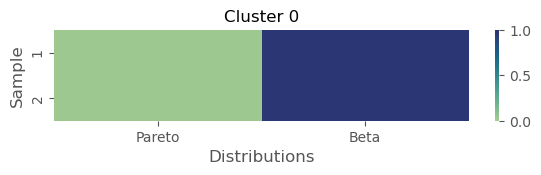

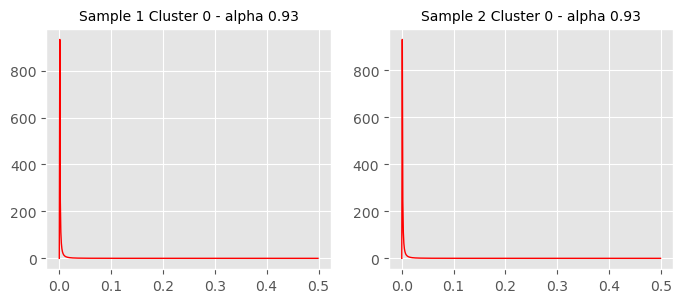

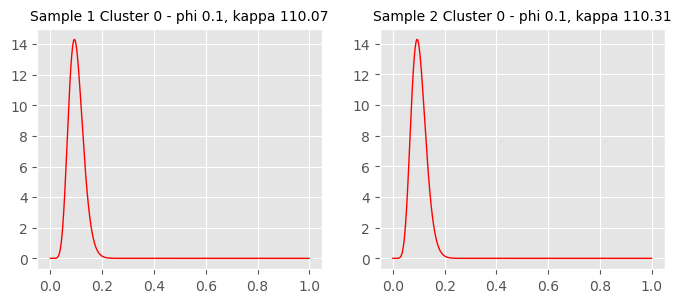

In [47]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [40]:
final_mb.params

{'weights_param': tensor([1.], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[0.9326, 0.9321]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.1002, 0.1009]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[110.0685, 110.3067]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.0304, 0.9696],
          [0.0309, 0.9691]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1.

### One pareto-pareto component

In [5]:
N1 = 1000
seed = 123

alpha_pareto_x = 1.2
alpha_pareto_y = 1.4
scale = 0.01
upper_bound = 0.5
n1=100
NV, DP = only_pareto_binomial_component(alpha_x=alpha_pareto_x, L_x=scale, H_x=upper_bound, alpha_y=alpha_pareto_y, L_y=scale, 
                                        H_y=upper_bound, n=n1, N=N1, seed = 123)

print(DP.shape)

torch.Size([1000, 2])


In [8]:
# alpha = alpha_pareto_x
# pareto_mean = alpha*scale/(alpha-1)
# print(pareto_mean)
# dim = 0
# print("Pareto lk: ", pareto_lk(NV[:, dim], DP[:, dim], alpha).sum())
# phi_beta = pareto_mean
# k_beta = torch.tensor(150.)
# a_beta = phi_beta * k_beta
# b_beta = (1-phi_beta) * k_beta
# print("Beta lk: ", beta_lk(NV[:, dim], DP[:, dim], a_beta, b_beta).sum())

# dim = 1
# print("Pareto lk: ", pareto_lk(NV[:, dim], DP[:, dim], alpha).sum())
# phi_beta = pareto_mean
# k_beta = torch.tensor(150.)
# a_beta = phi_beta * k_beta
# b_beta = (1-phi_beta) * k_beta
# print("Beta lk: ", beta_lk(NV[:, dim], DP[:, dim], a_beta, b_beta).sum())

In [9]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0100)
tensor(0.0100)


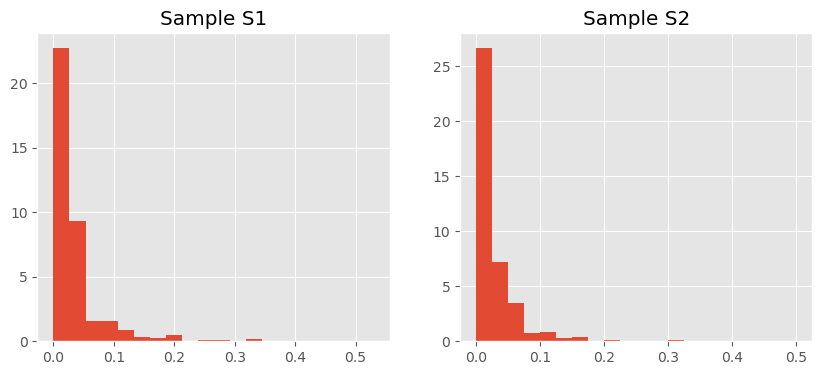

In [10]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), density = True, bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), density = True, bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [11]:
labels = np.zeros(N1)

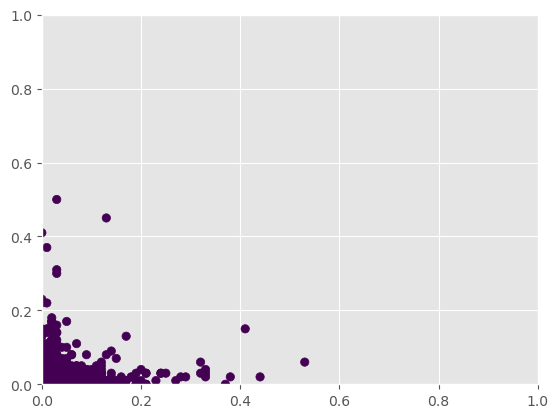

In [12]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K =  1
NV = 0 before: tensor(345)
NV = 0 after: tensor(0)
Beta:  tensor([[3.3755, 3.1793]])
Pareto:  tensor([[2.0190, 2.4463]])
Iteration 0: Loss = 5289978.5
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[0.9992, 1.0007]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.1000, 0.1000]], grad_fn=<AddBackward0>)
k_beta_param tensor([[199.6015, 199.6005]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.4010, 0.5990],
         [0.4010, 0.5990]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 4983798.0
Iteration 400: Loss = 4913858.5
Iteration 600: Loss = 5473967.0
Iteration 800: Loss = 4811101.0
Iteration 1000: Loss = 4787205.5
Iteration 1200: Loss = 4683313.0
Iteration 1400: Loss = 9364917.0
Iteration 1600: Loss = 4687082.5
Iteration 1800: Loss = 4924210.0
Iteration 2000: Loss = 4876168.5
Iteration 2200: Loss = 4696790.5
Iteration 2400: Loss = 4745989.0
Iteration 2600: Loss = 4569902.5
Iteration 2800: Loss = 4912397.5
Iteration 2999: Loss = 45984

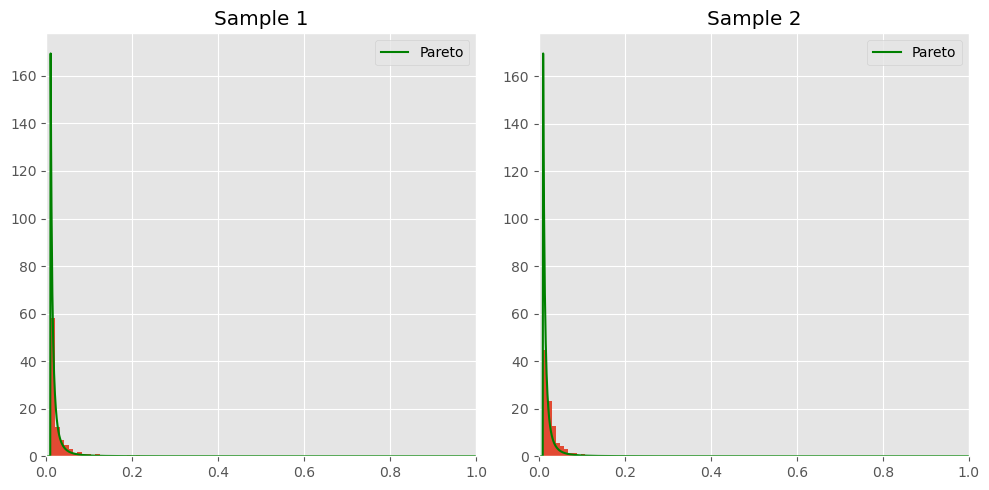

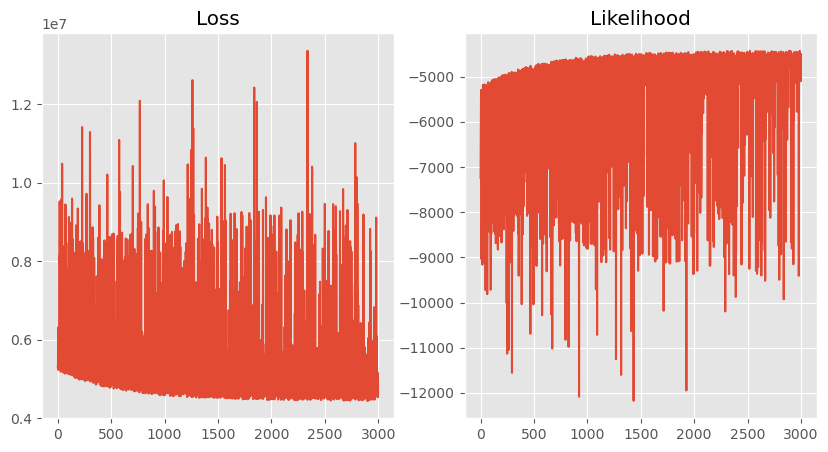

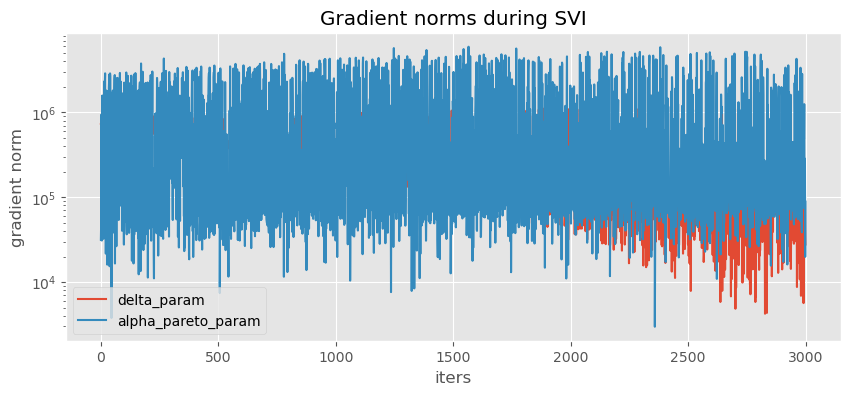

bic:  tensor(32071.1250, grad_fn=<RsubBackward1>)


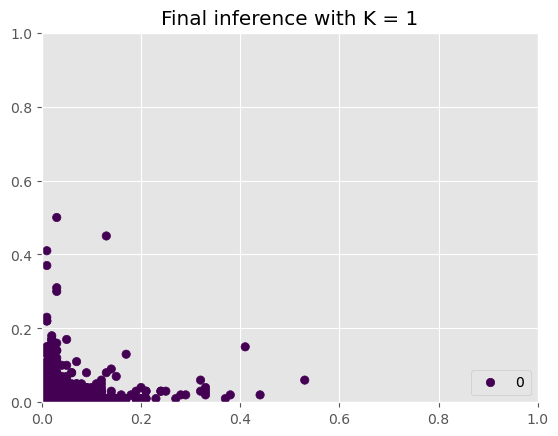

Selected number of clusters is:  1


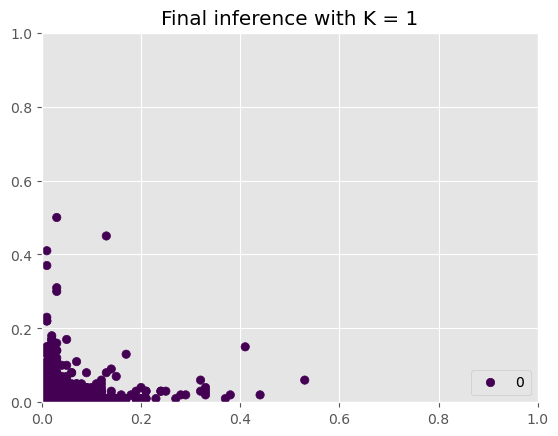

In [13]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [1], seed = 12, lr = 0.001)

In [21]:
print(compute_likelihood(final_mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(final_mb, beta = False, dim = 0, k = 0))

print(compute_likelihood(final_mb, beta = True, dim = 1, k = 0))
print(compute_likelihood(final_mb, beta = False, dim = 1, k = 0))

tensor(-5121.3950, grad_fn=<SumBackward0>)
tensor(-4533.4258, grad_fn=<SumBackward0>)
tensor(-5233.3687, grad_fn=<SumBackward0>)
tensor(-4607.0996, grad_fn=<SumBackward0>)


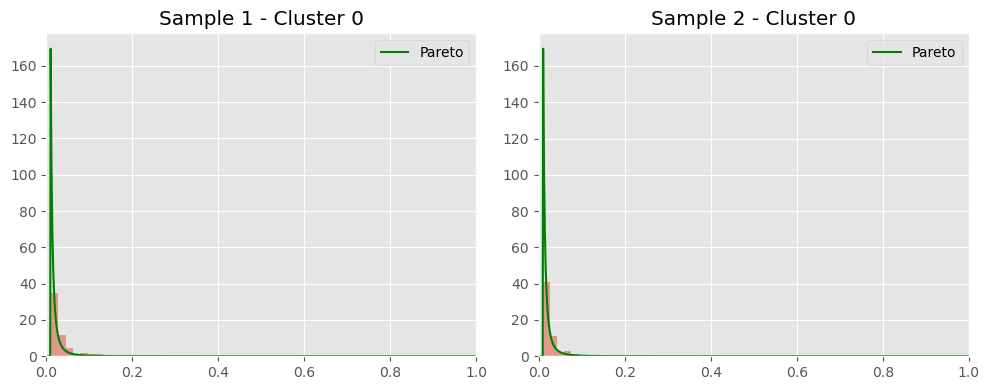

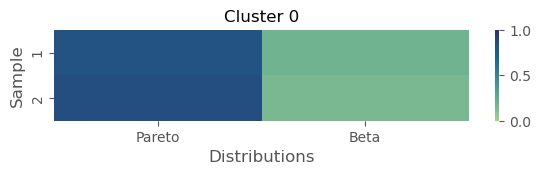

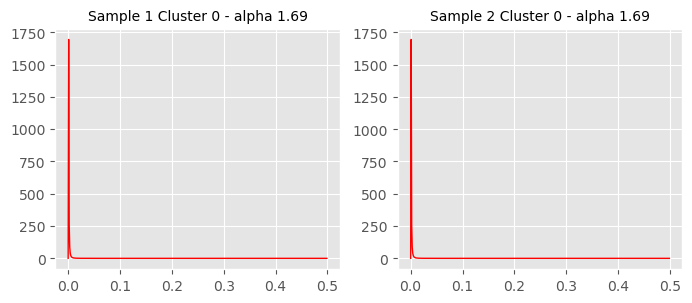

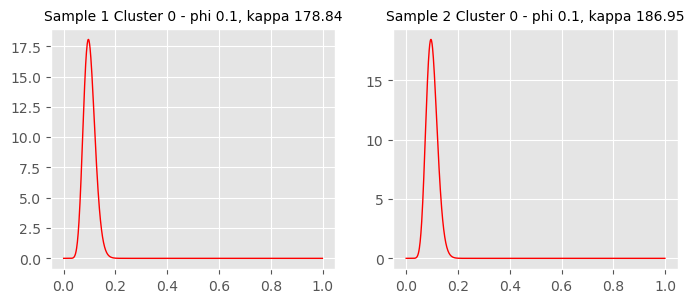

In [15]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [16]:
final_mb.params

{'weights_param': tensor([1.], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.6941, 1.6949]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.1000, 0.1000]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[178.8440, 186.9473]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.8100, 0.1900],
          [0.8451, 0.1549]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1.

### One beta-pareto component

In [3]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 1
L_pareto = 0.01
H_pareto = 0.5
phi_beta = 0.1
k_beta = 200
n1 = 100
NV, DP = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

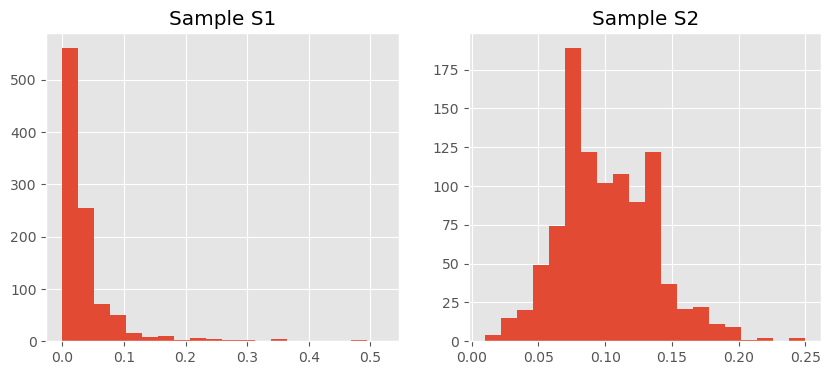

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [5]:
labels = np.zeros(N1)

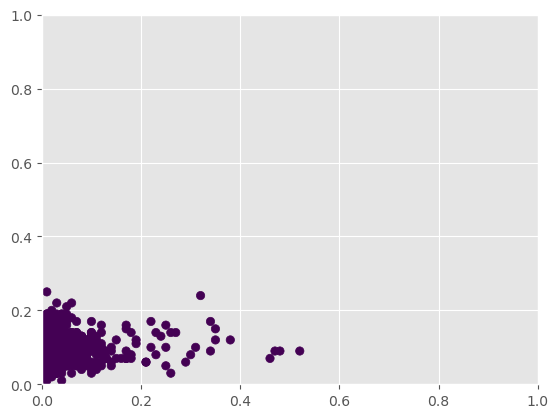

In [6]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K = 1 AND SEED = 15
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
Iteration 0: Loss = 6216092.0
Iteration 200: Loss = 7258947.0
Iteration 400: Loss = 5916625.0
Iteration 600: Loss = 5812789.5
Iteration 800: Loss = 5392121.5
Iteration 1000: Loss = 5691770.0
Iteration 1200: Loss = 5451979.5
Iteration 1400: Loss = 5978191.0
Iteration 1600: Loss = 5190850.0
Iteration 1800: Loss = 6602787.5
Iteration 2000: Loss = 5632541.5
Iteration 2200: Loss = 5460462.0
Iteration 2400: Loss = 5562759.0
Iteration 2600: Loss = 5096749.0
Iteration 2800: Loss = 5436318.5


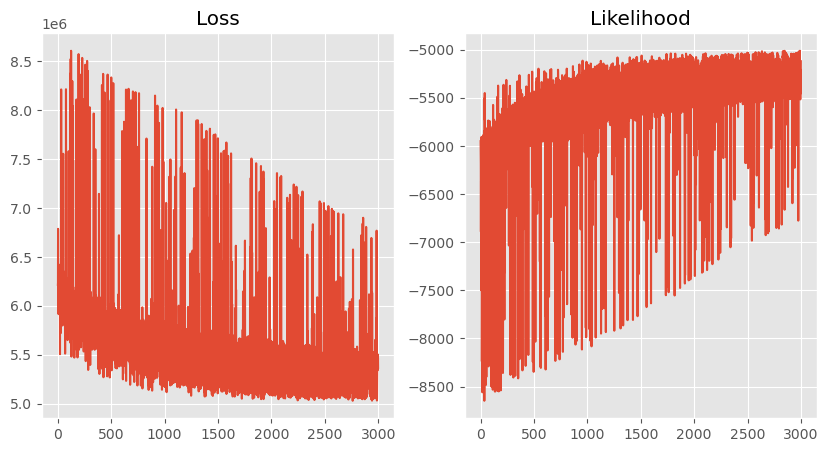

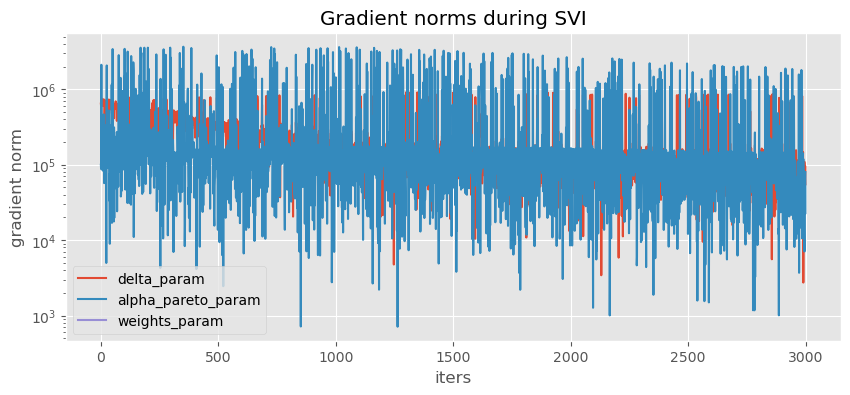

bic:  tensor(26512.8984, grad_fn=<RsubBackward1>)


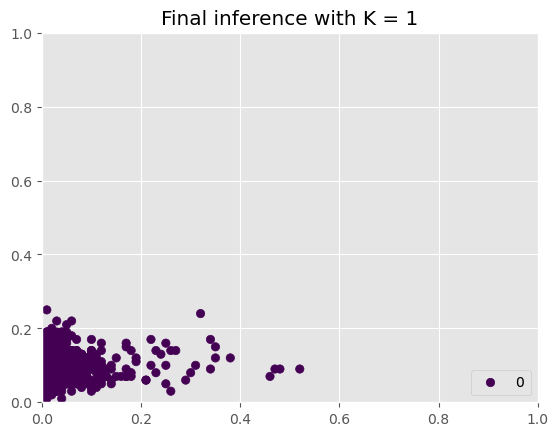

Selected number of clusters is 1 with seed 15


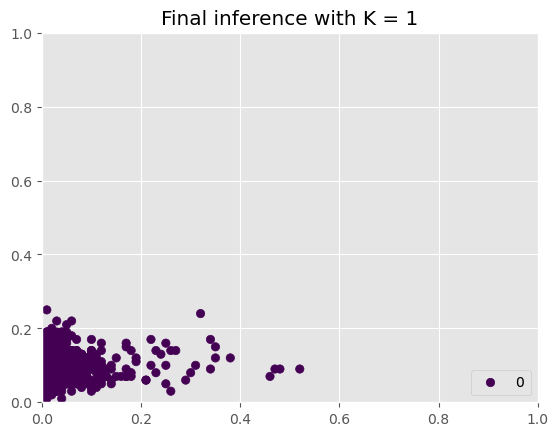

In [23]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [1], seed = [15], lr = 0.001)

In [26]:
print(compute_likelihood(final_mb, beta = True, dim = 0, k = 0)) # x axis, beta
print(compute_likelihood(final_mb, beta = False, dim = 0, k = 0)) # x axis, pareto
print(compute_likelihood(final_mb, beta = True, dim = 1, k = 0)) # y axis, beta
print(compute_likelihood(final_mb, beta = False, dim = 1, k = 0)) # y axis, pareto

tensor(-3215.6284, grad_fn=<SumBackward0>)
tensor(-4393.4614, grad_fn=<SumBackward0>)
tensor(-2665.4839, grad_fn=<SumBackward0>)
tensor(-3965.6226, grad_fn=<SumBackward0>)


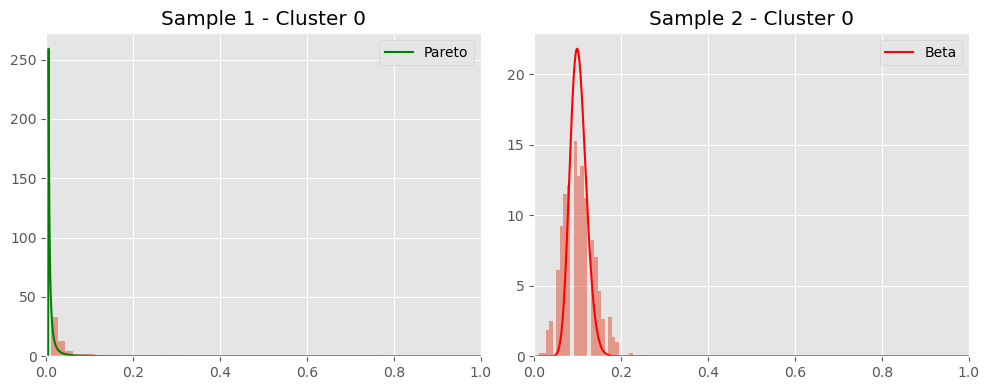

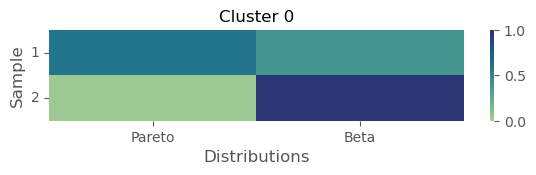

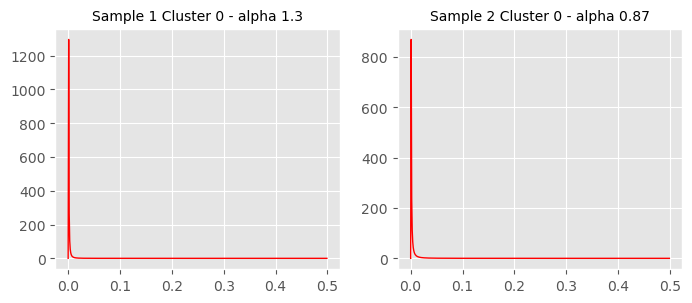

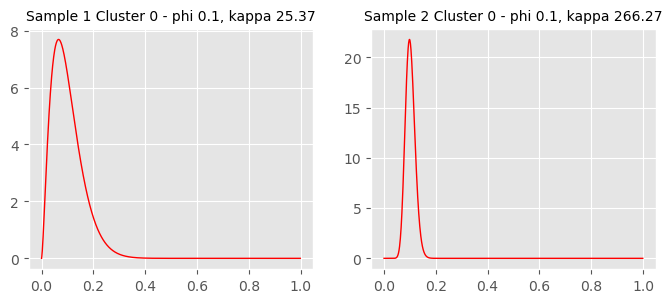

In [27]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [28]:
final_mb.params

{'weights_param': tensor([1.], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.6629, 0.9533]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.1000, 0.1019]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[167.3188, 203.4936]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.7635, 0.2365],
          [0.0359, 0.9641]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1.

### 2 beta-pareto components

In [110]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 1.5
L_pareto = 0.01
H_pareto = 0.5
phi_beta = 0.2
k_beta = 100
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Sample S2
phi_beta_x = 0.5
k_beta_x = 150
phi_beta_y = 0.5
k_beta_y= 150
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
print(NV.shape)
DP = torch.concat((DP1,DP2))
print(DP.shape)

torch.Size([1500, 2])
torch.Size([1500, 2])


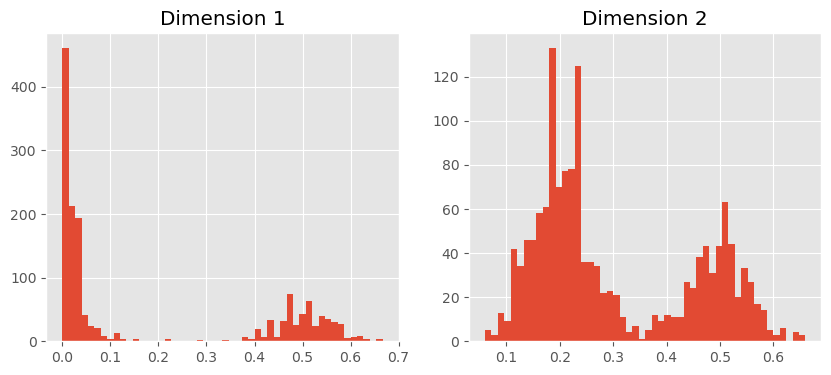

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [112]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))

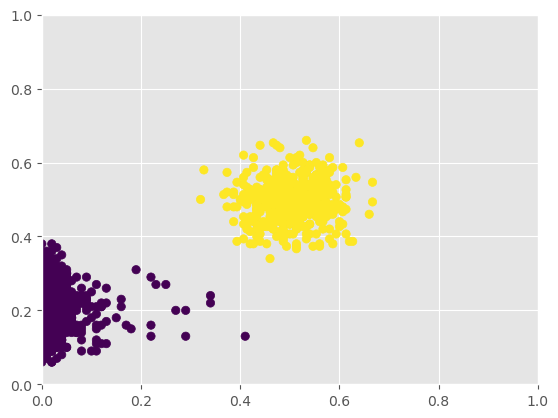

In [113]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K =  2
NV = 0 before: tensor(199)
NV = 0 after: tensor(0)
Beta:  tensor([[3.4143, 2.6391],
        [2.4193, 2.4140]])
Pareto:  tensor([[ 2.6184, -1.4104],
        [-3.2294, -3.2061]])
Iteration 0: Loss = 21474330.0
weights_param tensor([0.7135, 0.2865], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0007, 0.9993],
        [1.0008, 0.9991]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.1000, 0.2056],
        [0.5000, 0.5013]], grad_fn=<AddBackward0>)
k_beta_param tensor([[199.6398, 199.6406],
        [199.6026, 199.6142]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.4005, 0.5995],
         [0.3990, 0.6010]],

        [[0.3990, 0.6010],
         [0.3990, 0.6010]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 16233632.0
Iteration 400: Loss = 15704629.0
Iteration 600: Loss = 15433545.0
Iteration 800: Loss = 16719301.0
Iteration 1000: Loss = 14934869.0
Iteration 1200: Loss = 15157684.0
Iteration 1400: Loss = 14832494.0
Iteration 1600: Loss = 20055168.0
Iteration 1

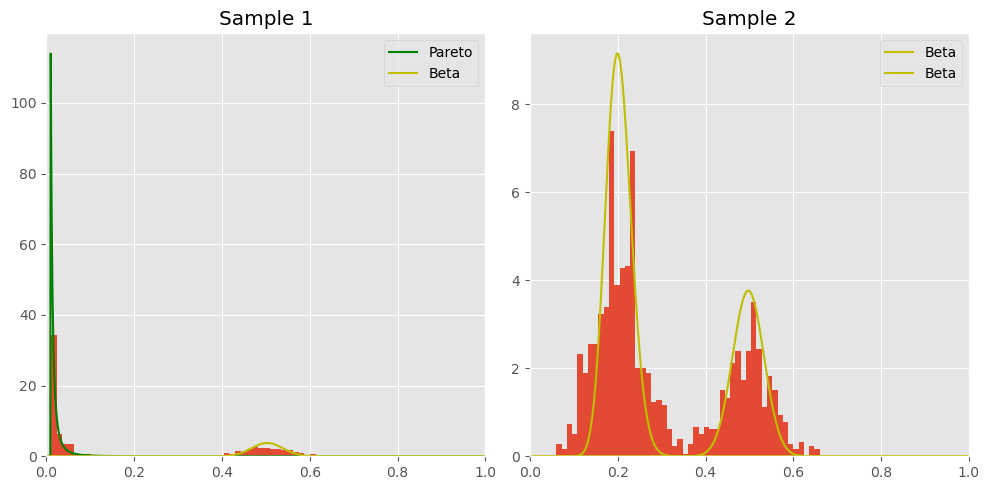

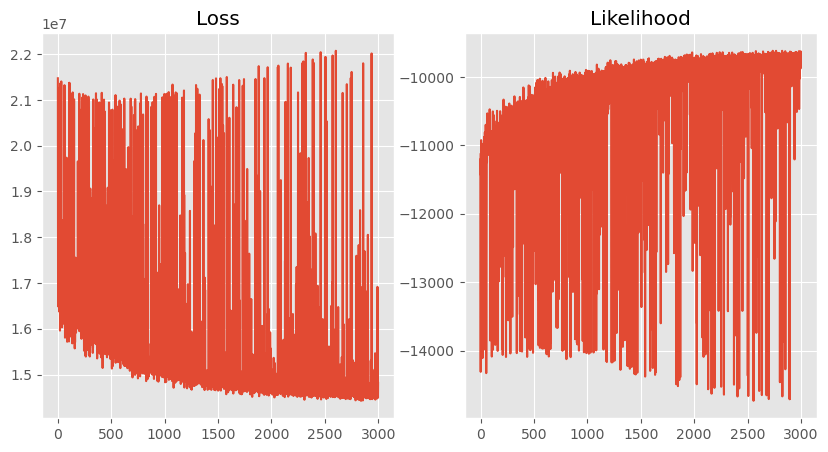

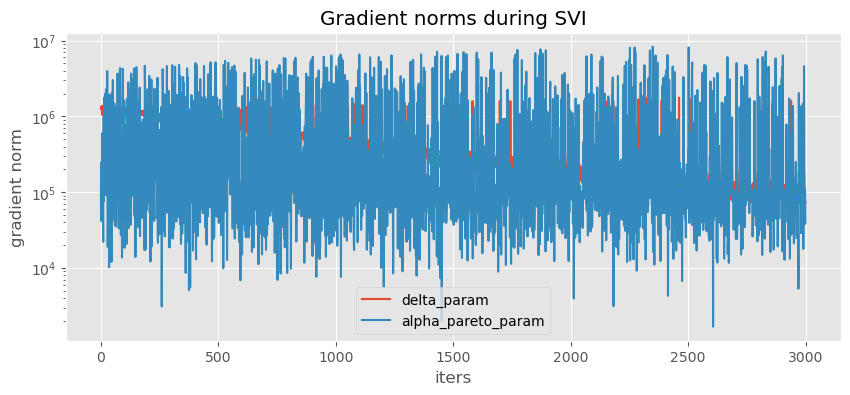

bic:  tensor(56818.3945, grad_fn=<RsubBackward1>)


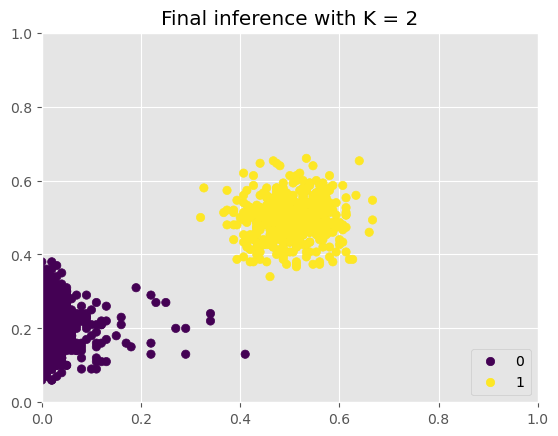

Selected number of clusters is:  2


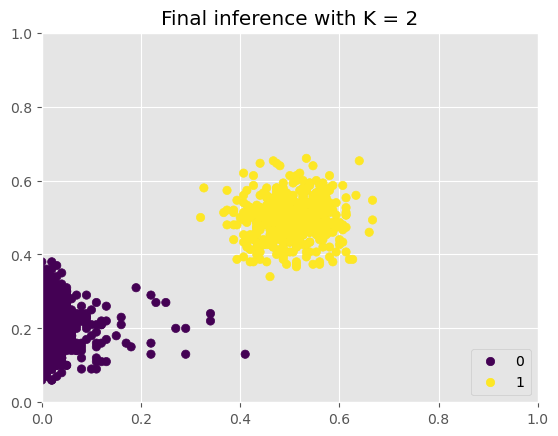

In [115]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [2], seed = 15, lr = 0.001)

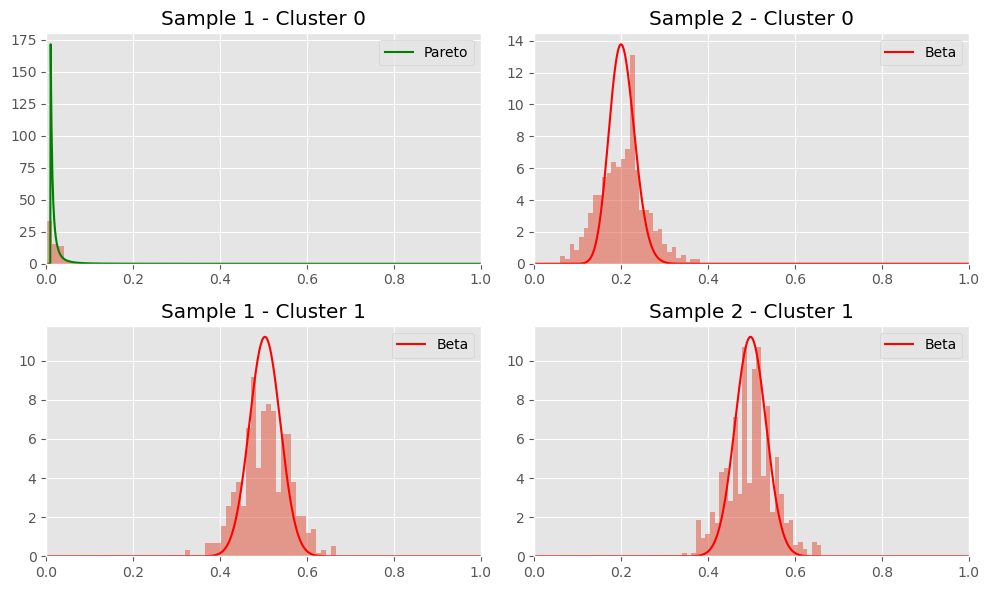

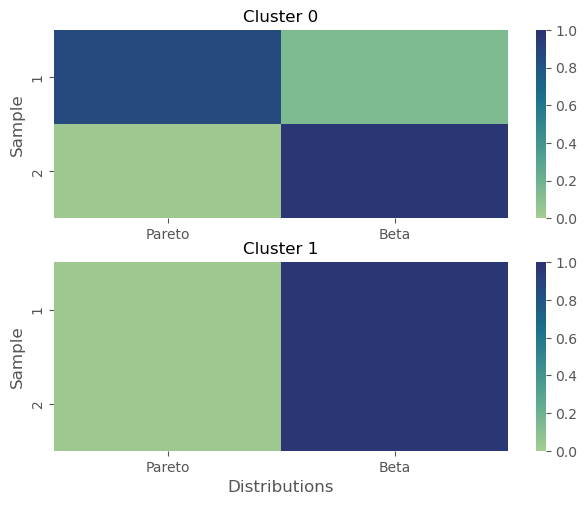

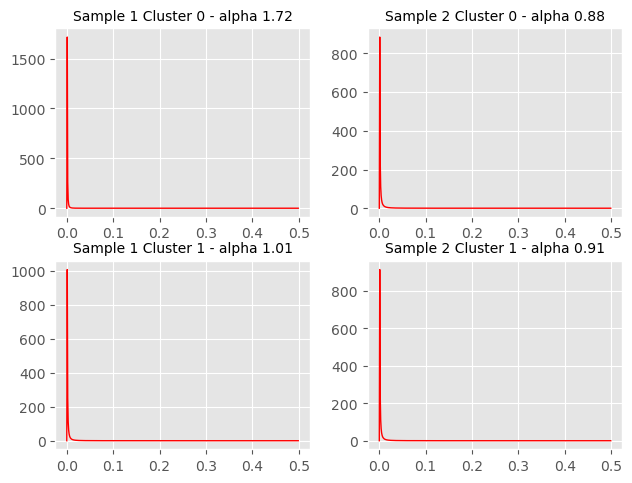

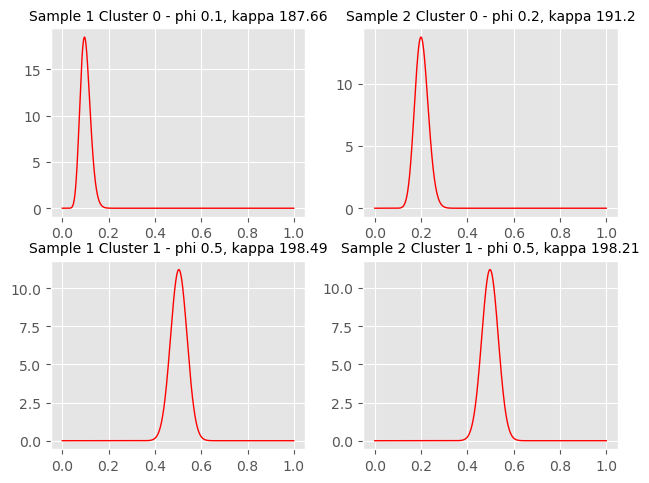

In [116]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [117]:
final_mb.params

{'weights_param': tensor([0.6645, 0.3355], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.7159, 0.8848],
         [1.0071, 0.9138]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.1000, 0.2024],
         [0.5030, 0.4973]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[187.6570, 191.2007],
         [198.4917, 198.2098]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.8665, 0.1335],
          [0.0297, 0.9703]],
 
         [[0.0301, 0.9699],
          [0.0292, 0.9708]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[9.9988e-01, 9.9968e-01, 9.9983e-01,  ..., 5.4628e-03, 3.1375e-03,
          3.5701e-03],
         [1.1965e-04, 3.2416e-04, 1.6587e-04,  ..., 9.9454e-01, 9.9686e-01,
          9.9643e-01]], grad_fn=<CopySlices>),
 'cluster_assignments': tensor([0, 0, 0,  ..., 1, 1, 1])}

In [118]:
sample = 1
d = sample-1
k = 0
data_NV = NV1[:,0]
data_DP = DP1[:,0]
data_VAF = data_NV/data_DP + 1e-3
alpha = final_mb.params["alpha_pareto_param"][k,d].detach()
phi_beta = final_mb.params["phi_beta_param"][k,d].detach()
kappa_beta = final_mb.params["k_beta_param"][k,d].detach()
print("Phi: ", phi_beta)
print("Kappa: ", kappa_beta)
print("Alpha: ", alpha)
a_beta = phi_beta * kappa_beta
b_beta = (1-phi_beta) * kappa_beta
beta_log = dist.Beta(a_beta, b_beta).log_prob(data_VAF)
# print("Beta log_prob", beta_log)
pareto_log = BoundedPareto(final_mb.pareto_L, alpha, final_mb.pareto_H).log_prob(data_VAF)
# print("Pareto log_prob", pareto_log)

beta_lk_value = beta_lk(data_NV, data_DP, a_beta, b_beta)
print("BetaBin lk: ", beta_lk_value.sum())
pareto_lk_value = pareto_lk(data_NV, data_DP, alpha) # return a tensor of shape data_NV.shape[0]
print("ParetoBin lk: ", pareto_lk_value.sum())


Phi:  tensor(0.1000)
Kappa:  tensor(187.6570)
Alpha:  tensor(1.7159)
BetaBin lk:  tensor(-5655.9375)
ParetoBin lk:  tensor(-4896.2451)


### 5 beta-pareto components

In [3]:
N1 = 100
N2 = 200
N3 = 100
N4 = 100
N5 = 400
N6 = 100
seed = 123
# Component 1
alpha_pareto = 1.2
L_pareto = 0.01
H_pareto = 0.5
phi_beta = 0.5
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)


# Component 2
phi_beta_x = 0.5
k_beta_x = 150
phi_beta_y = 0.5
k_beta_y= 150
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
DP = torch.concat((DP1,DP2))

# Component 3
phi_beta_x = 0.5
k_beta_x = 100
phi_beta_y = 1e-10
k_beta_y= 100
n3=150
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV3[:,1] = torch.tensor(0, dtype=NV3.dtype)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))


# Component 4
phi_beta_x = 0.3
k_beta_x = 150
phi_beta_y = 1e-10
k_beta_y= 150
n4=150
NV4, DP4 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n4, N=N4, seed=seed)
NV4[:,1] = torch.tensor(0, dtype=NV4.dtype)
NV = torch.concat((NV,NV4))
DP = torch.concat((DP,DP4))


# Component 5
alpha_pareto = 1.5
phi_beta = 1e-10
k_beta = 150
n5=150
NV5, DP5 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n5, N=N5, seed = seed)
NV5[:,1] = torch.tensor(0, dtype=NV1.dtype)
NV = torch.concat((NV,NV5))
DP = torch.concat((DP,DP5))
print(NV.shape)
print(DP.shape)


# Component 6
# phi_beta_x = 1e-10
# k_beta_x = 150
# phi_beta_y = 0.25
# k_beta_y= 150
# n6=150
# NV6, DP6 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n6, N=N6, seed=seed)
# NV6[:,0] = torch.tensor(0, dtype=NV6.dtype)
# NV = torch.concat((NV,NV6))
# DP = torch.concat((DP,DP6))

torch.Size([900, 2])
torch.Size([900, 2])


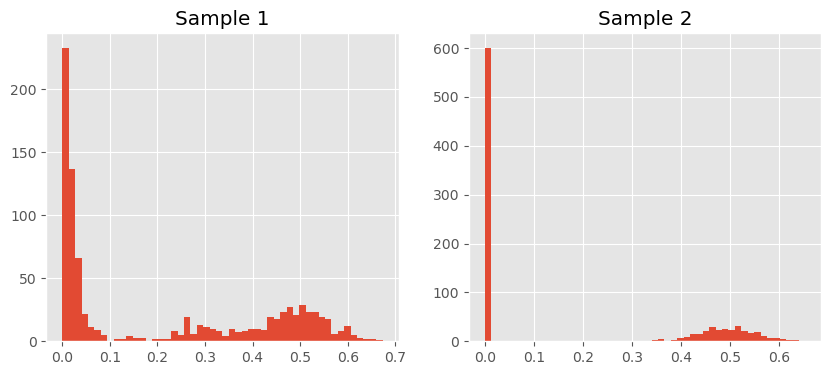

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Sample 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Sample 2")
plt.show()

In [5]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))
labels_3 = np.ones(N3)*2
labels = np.concatenate((labels, labels_3))
labels_4 = np.ones(N4)*3
labels = np.concatenate((labels, labels_4))
labels_5 = np.ones(N5)*4
labels = np.concatenate((labels, labels_5))
# labels_6 = np.ones(N6)*5
# labels = np.concatenate((labels, labels_6))

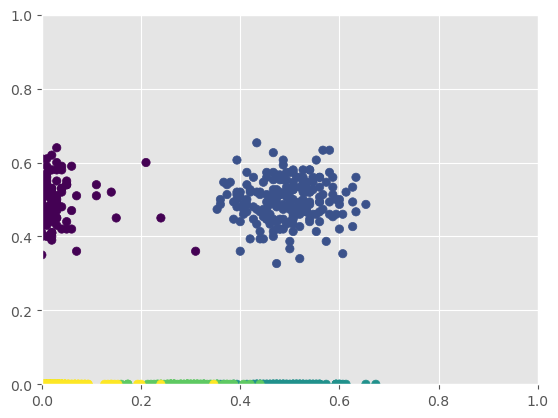

In [6]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K = 5 AND SEED = 40
NV = 0 before: tensor(655)
NV = 0 after: tensor(0)
Iteration 0: Loss = 11360253.0
Iteration 200: Loss = 7787329.5
Iteration 400: Loss = 9061645.0
Iteration 600: Loss = 6661900.5
Iteration 800: Loss = 6550548.0
Iteration 1000: Loss = 6462238.5
Iteration 1200: Loss = 6748013.5
Iteration 1400: Loss = 6439097.5
Iteration 1600: Loss = 6460517.5
Iteration 1800: Loss = 6452659.0
Iteration 2000: Loss = 7523686.0
Iteration 2200: Loss = 6444626.0
Iteration 2400: Loss = 6423621.5
Iteration 2600: Loss = 6419995.0
Iteration 2800: Loss = 6487411.0
Iteration 3000: Loss = 6574352.0
Iteration 3200: Loss = 6411042.0
Iteration 3400: Loss = 6426530.5
Iteration 3600: Loss = 6464443.0
Iteration 3800: Loss = 6425291.0
Iteration 4000: Loss = 6419467.5
Iteration 4200: Loss = 6443741.5
Iteration 4400: Loss = 6410518.0
Iteration 4600: Loss = 6411807.0
Iteration 4800: Loss = 6502880.5
Iteration 5000: Loss = 6407293.5
Iteration 5200: Loss = 6444267.0
Iteration 5400: Loss = 6410827.5
It

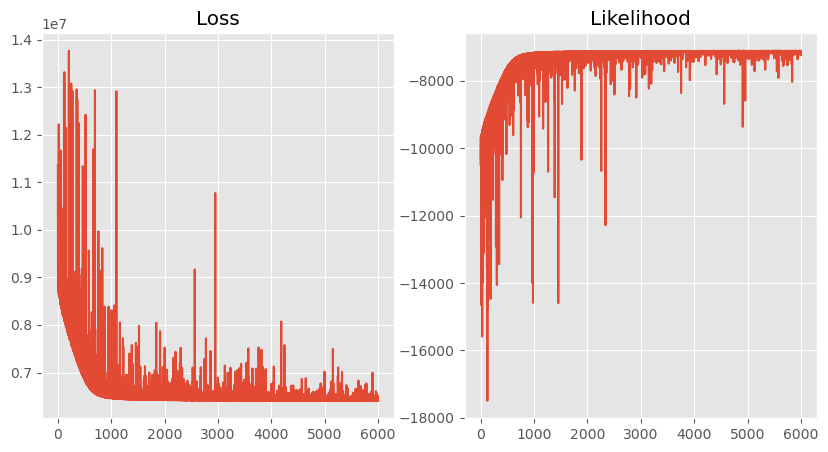

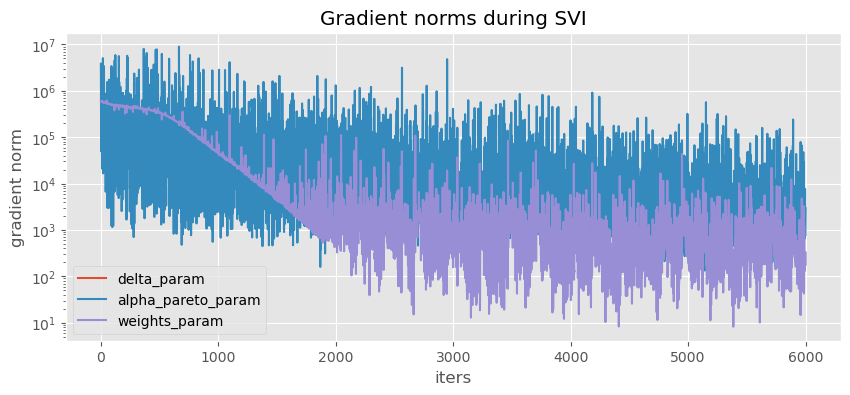

bic:  tensor(56158.4727, grad_fn=<RsubBackward1>)


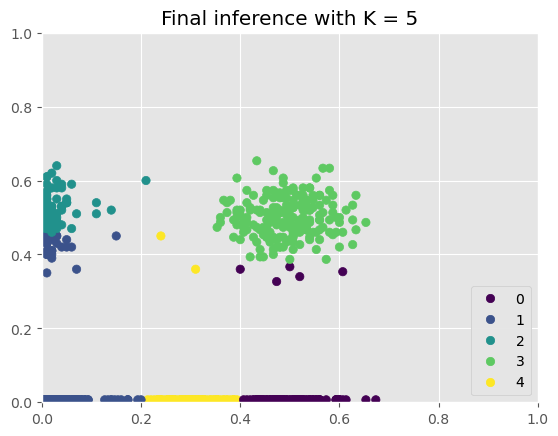

RUN WITH K = 5 AND SEED = 41
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
Iteration 0: Loss = 7027206.0
Iteration 200: Loss = 7727958.0
Iteration 400: Loss = 7129945.0
Iteration 600: Loss = 6494948.5
Iteration 800: Loss = 6605387.5
Iteration 1000: Loss = 6453035.5
Iteration 1200: Loss = 6445494.5
Iteration 1400: Loss = 6630770.0
Iteration 1600: Loss = 6464962.5
Iteration 1800: Loss = 6493270.5
Iteration 2000: Loss = 6422364.0
Iteration 2200: Loss = 6462591.0
Iteration 2400: Loss = 6525168.0
Iteration 2600: Loss = 6419247.0
Iteration 2800: Loss = 6413508.5
Iteration 3000: Loss = 6414633.0
Iteration 3200: Loss = 6412908.0
Iteration 3400: Loss = 6425821.0
Iteration 3600: Loss = 6417242.5
Iteration 3800: Loss = 6414571.0
Iteration 4000: Loss = 6412643.0
Iteration 4200: Loss = 6422425.0
Iteration 4400: Loss = 6506249.5
Iteration 4600: Loss = 6412415.0
Iteration 4800: Loss = 6410239.0
Iteration 5000: Loss = 6421094.5
Iteration 5200: Loss = 6474437.5
Iteration 5400: Loss = 6421443.0
Itera

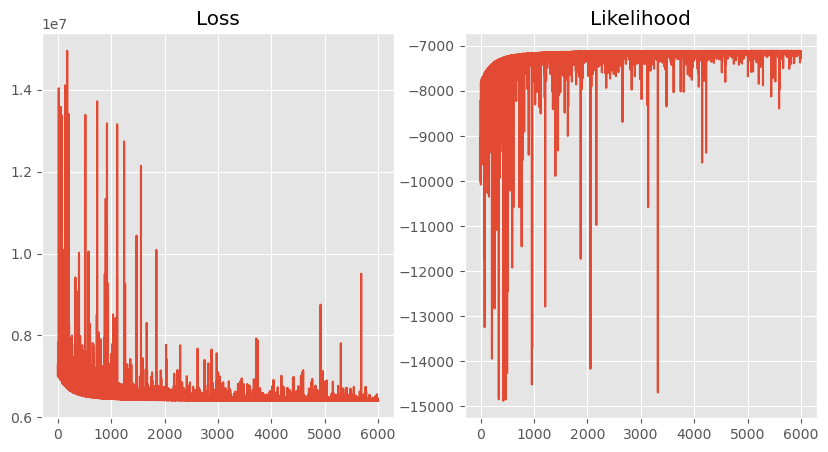

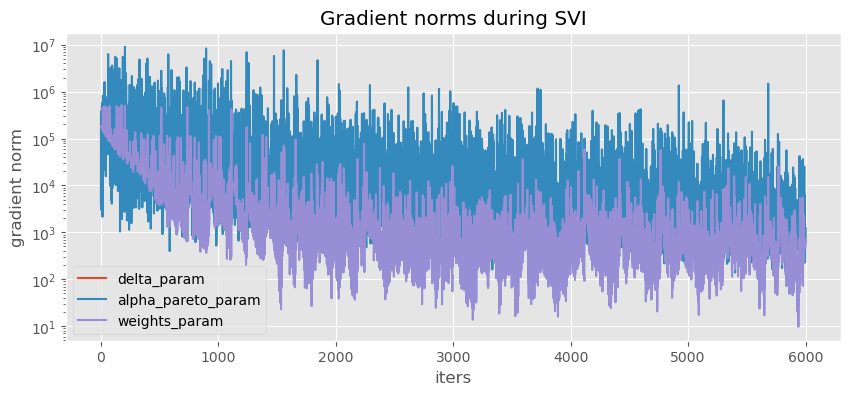

bic:  tensor(56164.7812, grad_fn=<RsubBackward1>)


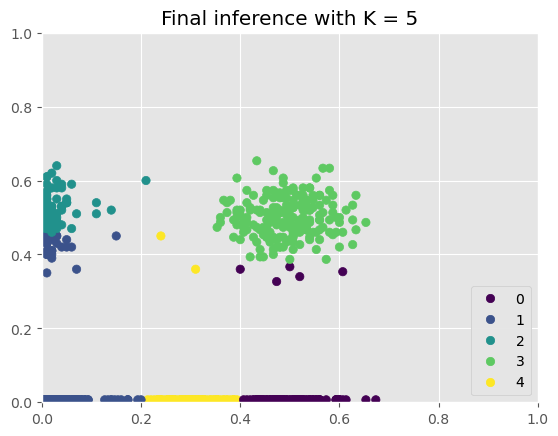

Selected number of clusters is 5 with seed 40


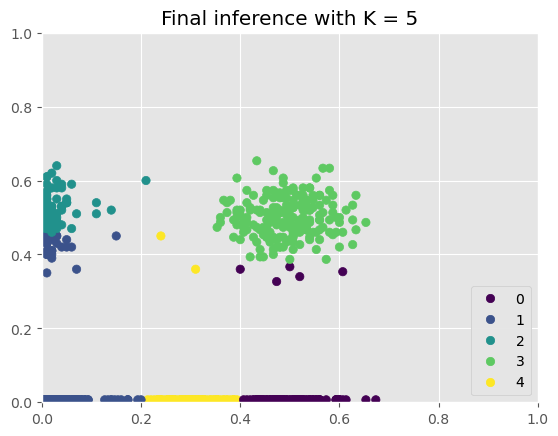

In [7]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 6000, K = [5], seed = [40,41], lr = 0.005)

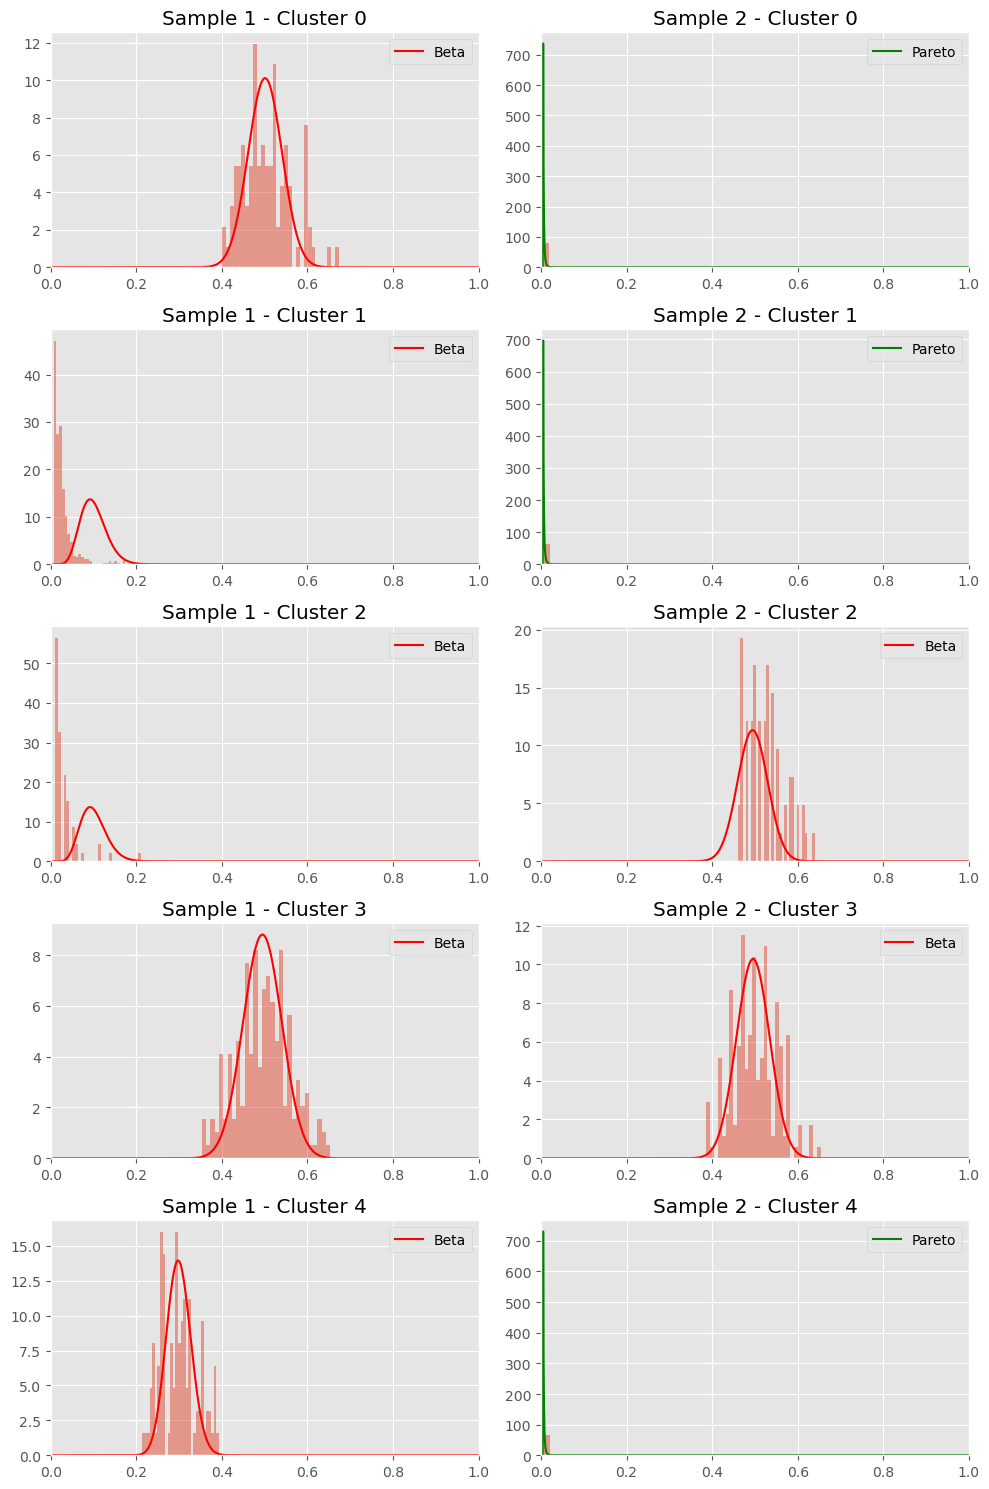

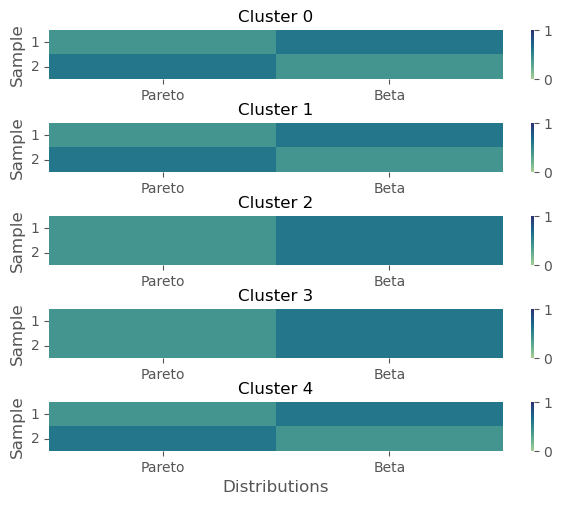

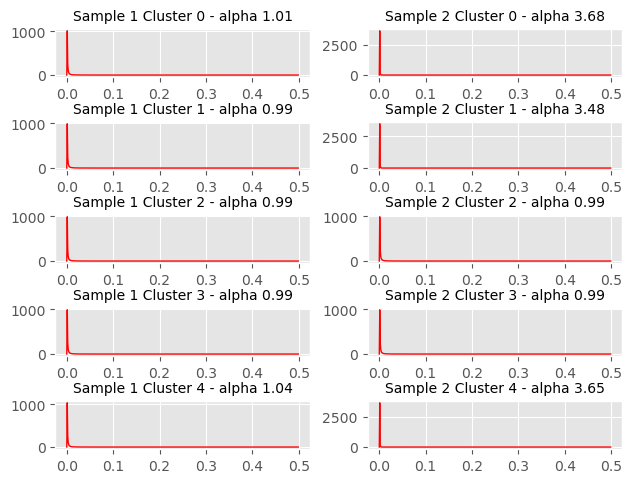

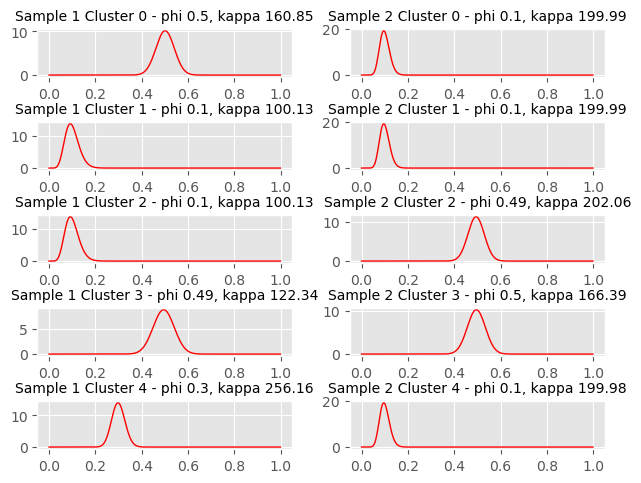

In [8]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

torch.Size([298])
Min vaf tensor(0.0067)


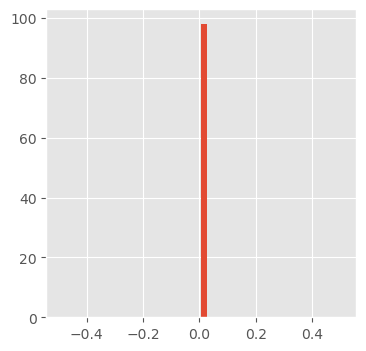

In [69]:
# CHECK LIKELIHOOD CLUSTER 4 SAMPLE 1
s = 2 # sample
k = 0 # cluster
d = s-1
labels = final_mb.params['cluster_assignments'].detach().numpy()
data_NV = NV[labels == k, d]
data_DP = DP[labels == k, d]
data_VAF = data_NV/data_DP
threshold = 0.2
data_VAF1 = data_VAF[data_VAF < threshold] # to check likelihood of data which are greater than 0.1
data_NV1 = data_NV[data_VAF < threshold] # i.e. what happens if data < 0.1 were assigned to a pareto in cluster 1
data_DP1 = data_DP[data_VAF < threshold]
print(data_VAF.shape)
plt.figure(figsize=(4, 4))
plt.hist(data_VAF1.numpy(), bins = 50);
# plt.ylim([0,60])
print("Min vaf", torch.min(data_VAF1))

In [81]:
d = 1
data_VAF = NV/DP
threshold = 0.2
idx_data = np.where((data_VAF[:,d] < threshold) & (labels == k))[0]
weights = final_mb.params["weights_param"]
print(data_VAF[idx_data[0],:])

print("K = 0")
print(sum_pareto_bin(final_mb, NV, DP, idx_data[0], k = 0))
print("\nK = 1")
print(sum_pareto_bin(final_mb, NV, DP, idx_data[0], k = 1))
print("\nWith weights:")
# print(weights[0]*sum_pareto_bin(final_mb, NV, DP, idx_data[0], k = 0))
# print(weights[1]*sum_pareto_bin(final_mb, NV, DP, idx_data[0], k = 1))
# compute_likelihood2(final_mb, NV, DP, beta = False, idx_data = idx_data[0], dim = 1, k = 0)

tensor([0.4867, 0.0067])
K = 0
delta_pareto_1 tensor(0.3327, grad_fn=<AddBackward0>)
delta_beta_1 tensor(0.6791, grad_fn=<AddBackward0>)
tensor(0.0675, grad_fn=<AddBackward0>)

K = 1
delta_pareto_1 tensor(0.9092, grad_fn=<AddBackward0>)
delta_beta_1 tensor(0.1022, grad_fn=<AddBackward0>)
tensor(0.0547, grad_fn=<AddBackward0>)

With weights:


In [10]:
final_mb.params

{'weights_param': tensor([0.3639, 0.1673, 0.1479, 0.1297, 0.1912], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[0.9971, 1.3197],
         [1.0108, 1.3666],
         [1.0687, 1.3470],
         [1.1072, 1.7324],
         [1.0007, 1.7618]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.4992, 0.4974],
         [0.5043, 0.1000],
         [0.1000, 0.4951],
         [0.1000, 0.1000],
         [0.3007, 0.1000]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[176.2034, 208.1222],
         [120.6482, 199.8426],
         [161.0185, 197.9813],
         [154.0135, 199.9652],
         [199.8573, 199.5129]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.0855, 0.9145],
          [0.0874, 0.9126]],
 
         [[0.1593, 0.8407],
          [0.9659, 0.0341]],
 
         [[0.7446, 0.2554],
          [0.1173, 0.8827]],
 
         [[0.8387, 0.1613],
          [0.9710, 0.0290]],
 
         [[0.1284, 0.8716],
          [0.9726, 0.0274]]], grad_fn=<DivBackward0>),
 'responsib': t

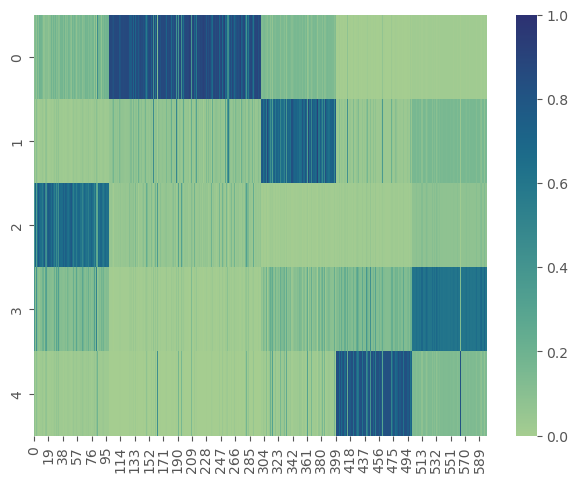

In [11]:
plot_responsib(final_mb)

### rRACES data

In [3]:
NV_r = pd.read_csv("./rRACES_data/NV2.csv")
DP_r = pd.read_csv("./rRACES_data/DP2.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([593, 2])
torch.Size([593, 2])


In [4]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0097)
tensor(0.0092)


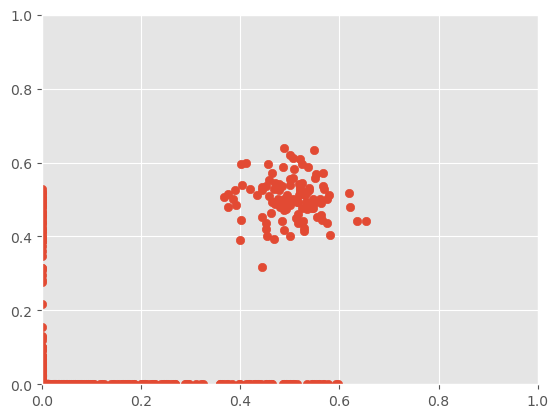

In [5]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

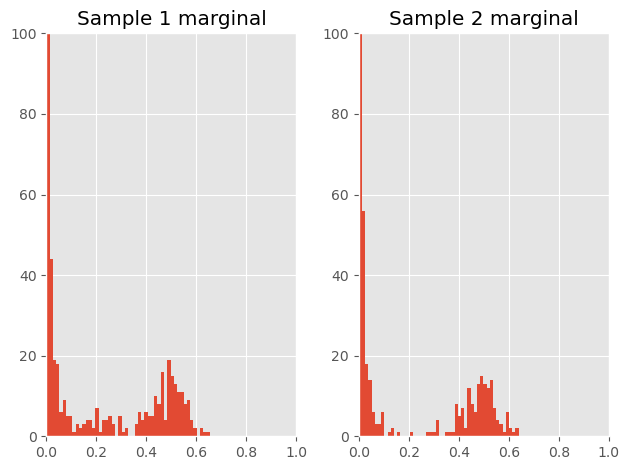

In [6]:
# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[2.1703e-01, 4.4703e-08],
        [4.9993e-01, 5.0346e-01],
        [1.0000e-03, 4.2671e-01],
        [4.6957e-01, 4.4703e-08],
        [1.4685e-02, 1.4474e-02]])
Cluster Sizes: [ 50 105  46  58 334]
Cluster Sizes Vector: [0.08431703 0.17706577 0.07757167 0.09780776 0.56323777]
Cluster variances [[331.7503658  331.7503658 ]
 [150.79538045 150.79538045]
 [218.94510456 218.94510456]
 [253.59698898 253.59698898]
 [856.990159   856.990159  ]]


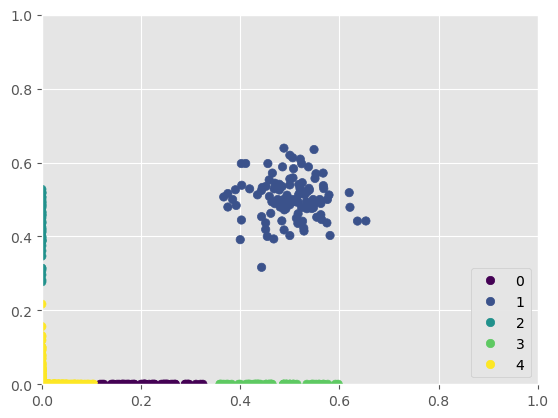

In [7]:
from sklearn.cluster import KMeans
K = 5
kmeans = KMeans(n_clusters=K, random_state=123, n_init=2).fit((NV/DP).numpy())
labels = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

plt.xlim([0,1])
plt.ylim([0,1])
sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)
legend1 = plt.legend(*sc.legend_elements(), loc="lower right")
plt.gca().add_artist(legend1)

# print(labels.astype(int))
# Compute cluster sizes
cluster_sizes = np.bincount(labels.astype(int), minlength=K)
print("Cluster Sizes:", cluster_sizes)

# Convert to a 1D vector
cluster_sizes_vector = cluster_sizes.reshape(-1)/np.sum(cluster_sizes.reshape(-1))
print("Cluster Sizes Vector:", cluster_sizes_vector)

centroids = kmeans.cluster_centers_
variances = []
for i in range(kmeans.n_clusters):
    vaf = NV/DP
    points_in_cluster = vaf[labels == i]
    
    # Get the centroid of the current cluster
    centroid = centroids[i]

    # Calculate the squared distances of points to the centroid
    distances = np.linalg.norm(points_in_cluster - centroid, axis=1) ** 2

    # Compute the variance (mean of squared distances)
    cluster_variance = np.mean(distances)
    variances.append(cluster_variance)

kappas = [1 / variance if variance > 0 else np.inf for variance in variances]
kappas = np.tile(kappas, (NV.shape[1], 1)).T
print("Cluster variances", kappas)

RUN WITH K = 5 AND SEED = 40
NV = 0 before: tensor(488)
NV = 0 after: tensor(0)
Iteration 0: Loss = 2120792.75
Iteration 200: Loss = 2092879.5
Iteration 400: Loss = 2335480.5
Iteration 600: Loss = 1999258.0
Iteration 800: Loss = 1985063.375
Iteration 1000: Loss = 1985595.875
Iteration 1200: Loss = 1880614.875
Iteration 1400: Loss = 1887468.875
Iteration 1600: Loss = 1849677.0
Iteration 1800: Loss = 1872764.375
Iteration 2000: Loss = 1846055.5
Iteration 2200: Loss = 1898827.375
Iteration 2400: Loss = 1921600.375
Iteration 2600: Loss = 1869246.75
Iteration 2800: Loss = 2069198.875
Iteration 3000: Loss = 1892612.125
Iteration 3200: Loss = 1897512.0
Iteration 3400: Loss = 1948730.75
Iteration 3600: Loss = 1907780.625
Iteration 3800: Loss = 1880177.875
Iteration 4000: Loss = 1902450.875
Iteration 4200: Loss = 1944132.5
Iteration 4400: Loss = 1901087.75
Iteration 4600: Loss = 1889400.25
Iteration 4800: Loss = 1905855.125


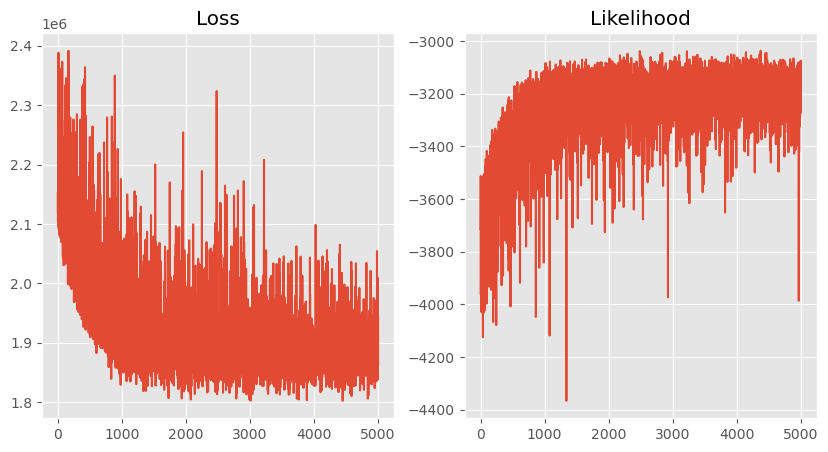

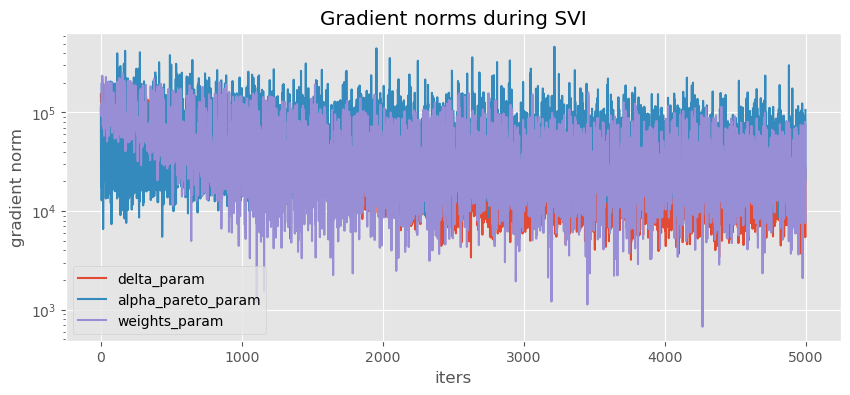

bic:  tensor(32520.4844, grad_fn=<RsubBackward1>)


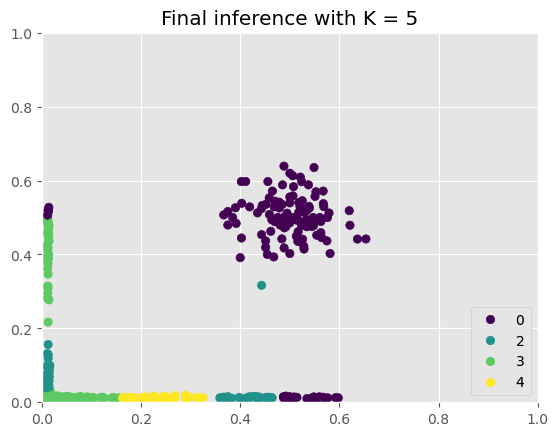

RUN WITH K = 5 AND SEED = 41
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
Iteration 0: Loss = 2248371.0
Iteration 200: Loss = 2283662.0
Iteration 400: Loss = 2131921.5
Iteration 600: Loss = 2019982.75
Iteration 800: Loss = 1952936.5
Iteration 1000: Loss = 1948850.625
Iteration 1200: Loss = 1920083.25
Iteration 1400: Loss = 1891355.625
Iteration 1600: Loss = 1850385.875
Iteration 1800: Loss = 1905867.0
Iteration 2000: Loss = 1931231.375
Iteration 2200: Loss = 1897438.0
Iteration 2400: Loss = 1893333.375
Iteration 2600: Loss = 1871451.625
Iteration 2800: Loss = 1921715.75
Iteration 3000: Loss = 1873339.25
Iteration 3200: Loss = 1844569.5
Iteration 3400: Loss = 1926711.875
Iteration 3600: Loss = 1868801.625
Iteration 3800: Loss = 1895792.75
Iteration 4000: Loss = 1845774.875
Iteration 4200: Loss = 1930464.375
Iteration 4400: Loss = 1869636.75
Iteration 4600: Loss = 1830909.25
Iteration 4800: Loss = 1959921.0


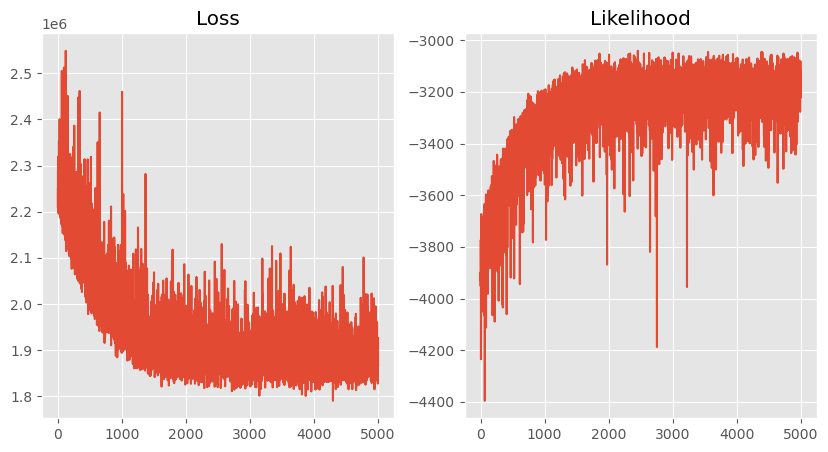

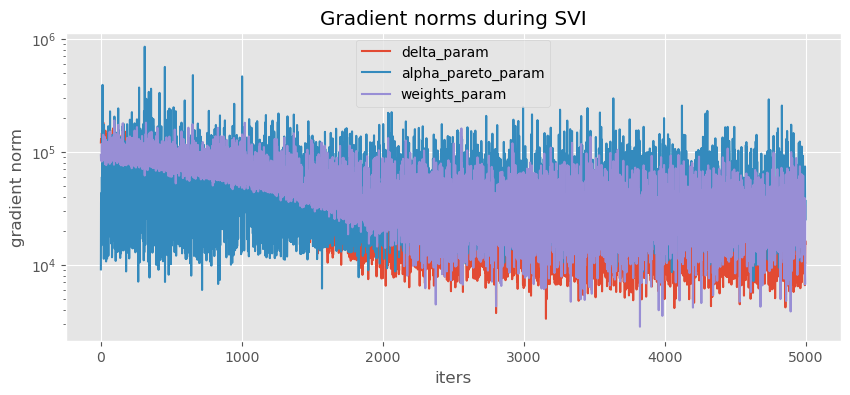

bic:  tensor(32516.6172, grad_fn=<RsubBackward1>)


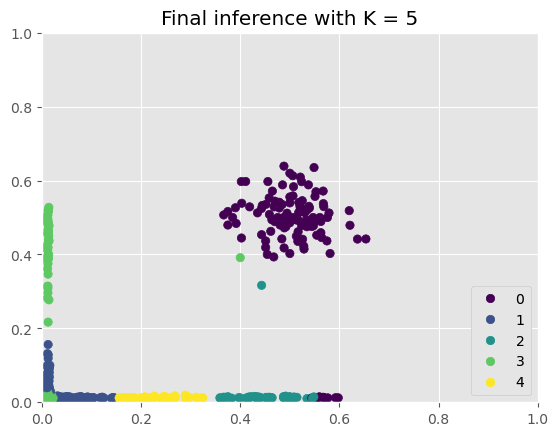

RUN WITH K = 5 AND SEED = 42
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
Iteration 0: Loss = 2028623.75
Iteration 200: Loss = 1974418.125
Iteration 400: Loss = 2027353.75
Iteration 600: Loss = 1947375.375
Iteration 800: Loss = 2016271.75
Iteration 1000: Loss = 1931496.25
Iteration 1200: Loss = 1882722.625
Iteration 1400: Loss = 1905884.875
Iteration 1600: Loss = 1883949.375
Iteration 1800: Loss = 2029732.5
Iteration 2000: Loss = 1994279.5
Iteration 2200: Loss = 1856966.5
Iteration 2400: Loss = 1946787.125
Iteration 2600: Loss = 1879595.75
Iteration 2800: Loss = 1860111.75
Iteration 3000: Loss = 1893760.5
Iteration 3200: Loss = 1858194.5
Iteration 3400: Loss = 1882750.75
Iteration 3600: Loss = 1931093.25
Iteration 3800: Loss = 1922834.75
Iteration 4000: Loss = 1883413.0
Iteration 4200: Loss = 1842526.375
Iteration 4400: Loss = 1899160.0
Iteration 4600: Loss = 2008197.875
Iteration 4800: Loss = 1885472.875


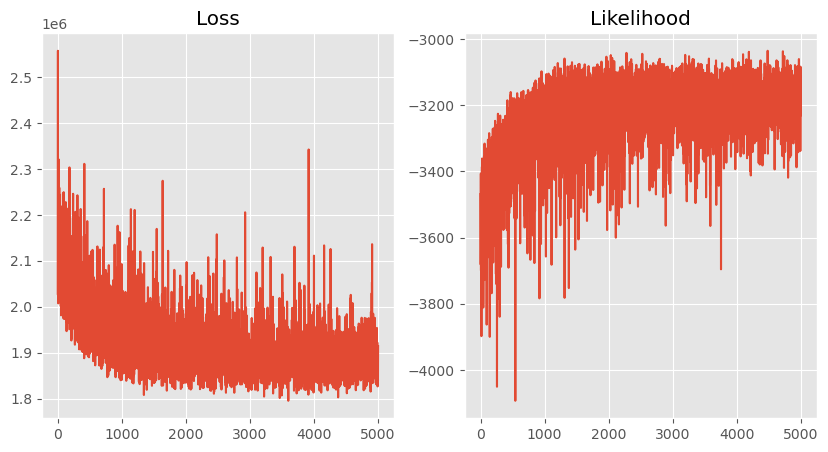

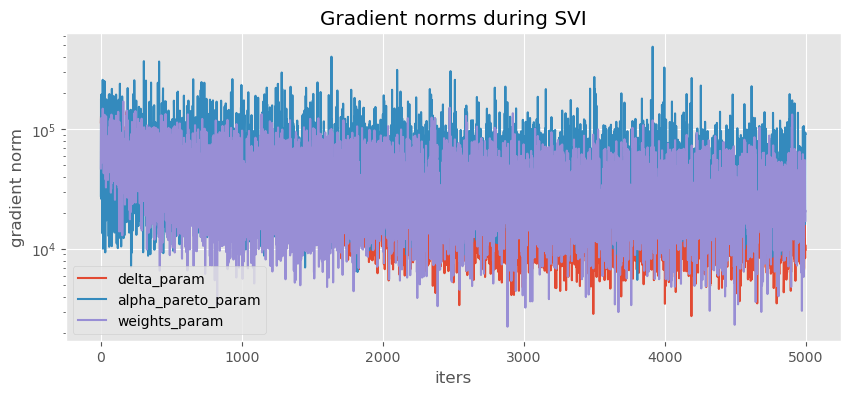

bic:  tensor(32518.4727, grad_fn=<RsubBackward1>)


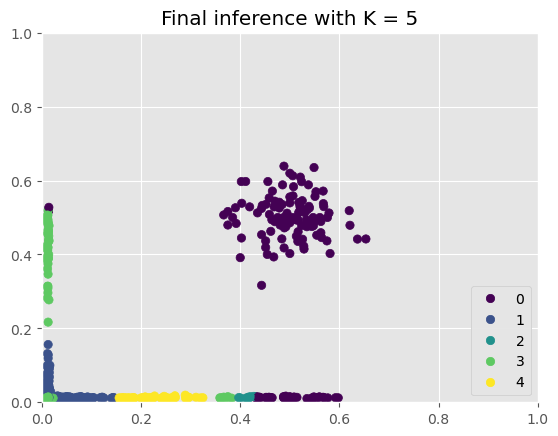

RUN WITH K = 6 AND SEED = 40
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
Iteration 0: Loss = 2050211.75
Iteration 200: Loss = 2000786.625
Iteration 400: Loss = 1982652.375
Iteration 600: Loss = 1958634.5
Iteration 800: Loss = 1946509.5
Iteration 1000: Loss = 1964914.625
Iteration 1200: Loss = 1896516.25
Iteration 1400: Loss = 1875627.5
Iteration 1600: Loss = 1902869.0
Iteration 1800: Loss = 1893411.25
Iteration 2000: Loss = 1918385.375
Iteration 2200: Loss = 1852930.375
Iteration 2400: Loss = 1832397.0
Iteration 2600: Loss = 1873388.875
Iteration 2800: Loss = 1935577.875
Iteration 3000: Loss = 1856238.875
Iteration 3200: Loss = 1941881.25
Iteration 3400: Loss = 1875422.875
Iteration 3600: Loss = 1905152.625
Iteration 3800: Loss = 1936367.375
Iteration 4000: Loss = 1868768.625
Iteration 4200: Loss = 1872003.75
Iteration 4400: Loss = 1825392.0
Iteration 4600: Loss = 1939791.875
Iteration 4800: Loss = 1841277.0


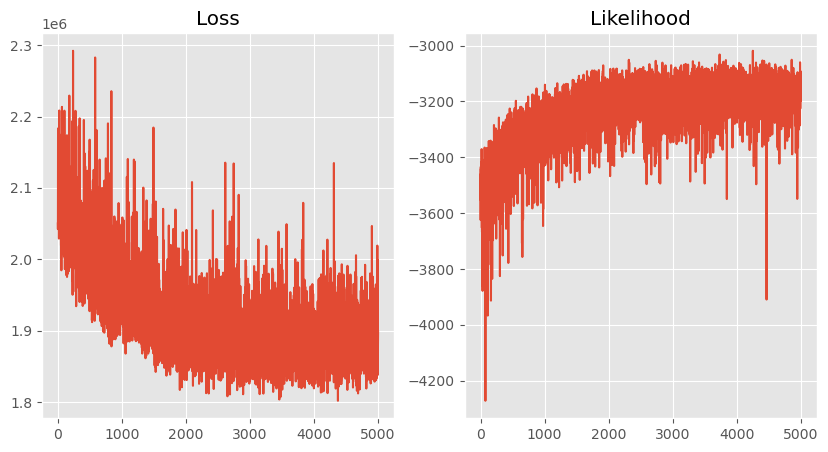

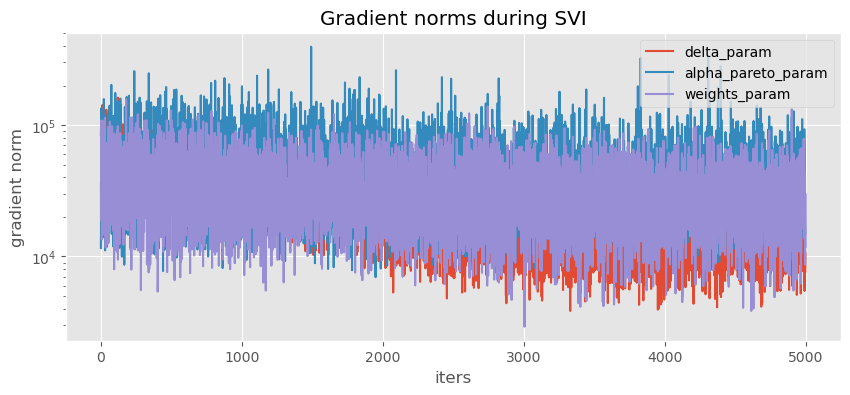

bic:  tensor(36375.0273, grad_fn=<RsubBackward1>)


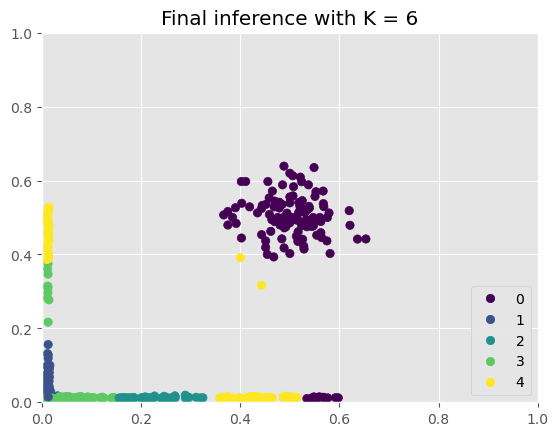

RUN WITH K = 6 AND SEED = 41
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
Iteration 0: Loss = 2169261.0
Iteration 200: Loss = 2121733.5
Iteration 400: Loss = 1996585.125
Iteration 600: Loss = 2024764.625
Iteration 800: Loss = 1919700.875
Iteration 1000: Loss = 1916279.5
Iteration 1200: Loss = 1909888.5
Iteration 1400: Loss = 1952261.875
Iteration 1600: Loss = 1903679.5
Iteration 1800: Loss = 1991930.375
Iteration 2000: Loss = 1942898.875
Iteration 2200: Loss = 1864321.25
Iteration 2400: Loss = 1819542.75
Iteration 2600: Loss = 1868810.375
Iteration 2800: Loss = 1886324.125
Iteration 3000: Loss = 1855832.875
Iteration 3200: Loss = 1867707.0
Iteration 3400: Loss = 1868280.0
Iteration 3600: Loss = 1893260.0
Iteration 3800: Loss = 1820413.625
Iteration 4000: Loss = 1891852.625
Iteration 4200: Loss = 1886469.75
Iteration 4400: Loss = 1891901.75
Iteration 4600: Loss = 1885157.125
Iteration 4800: Loss = 1883529.125


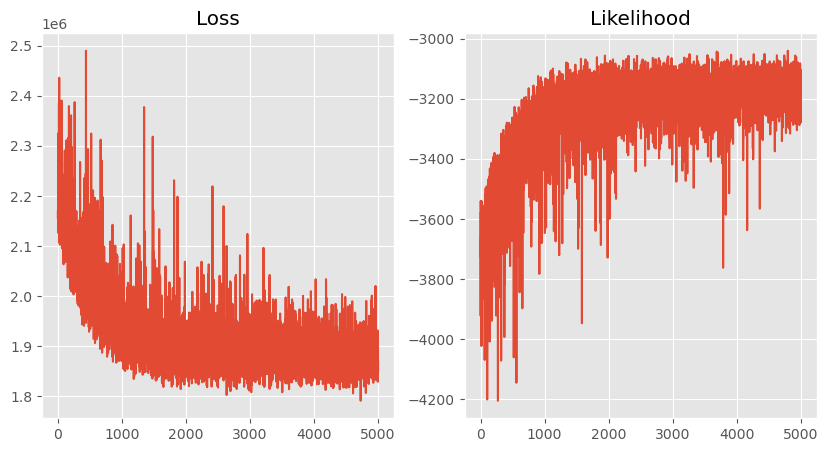

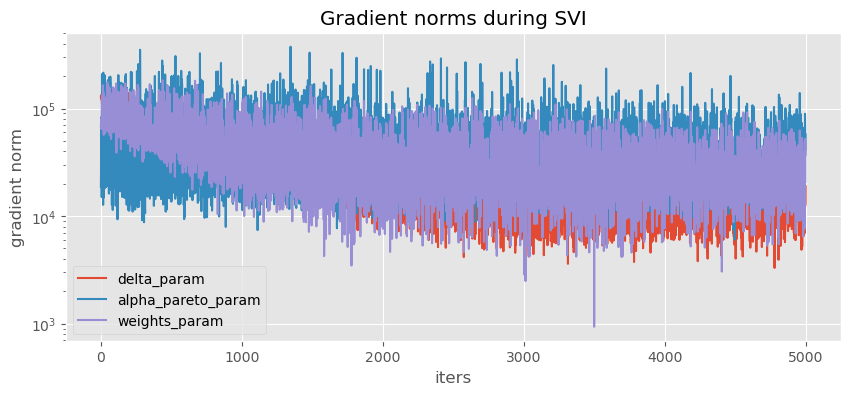

bic:  tensor(36372.1484, grad_fn=<RsubBackward1>)


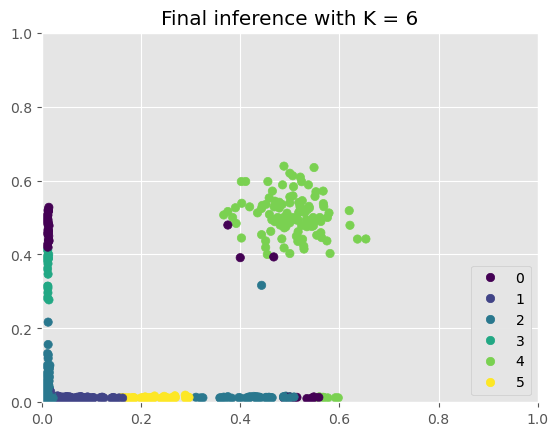

RUN WITH K = 6 AND SEED = 42
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
Iteration 0: Loss = 2032123.25
Iteration 200: Loss = 1978781.375
Iteration 400: Loss = 1921680.0
Iteration 600: Loss = 1936830.625
Iteration 800: Loss = 1892312.375
Iteration 1000: Loss = 1884808.25
Iteration 1200: Loss = 1927011.375
Iteration 1400: Loss = 1900181.5
Iteration 1600: Loss = 1882232.625
Iteration 1800: Loss = 1912691.25
Iteration 2000: Loss = 1859426.75
Iteration 2200: Loss = 1859337.75
Iteration 2400: Loss = 1871519.375
Iteration 2600: Loss = 1872226.25
Iteration 2800: Loss = 1970664.25
Iteration 3000: Loss = 1890382.5
Iteration 3200: Loss = 1868141.125
Iteration 3400: Loss = 1885052.0
Iteration 3600: Loss = 1849926.125
Iteration 3800: Loss = 1845902.125
Iteration 4000: Loss = 1876879.375
Iteration 4200: Loss = 1850275.5
Iteration 4400: Loss = 1889967.75
Iteration 4600: Loss = 1953662.75
Iteration 4800: Loss = 1886548.25


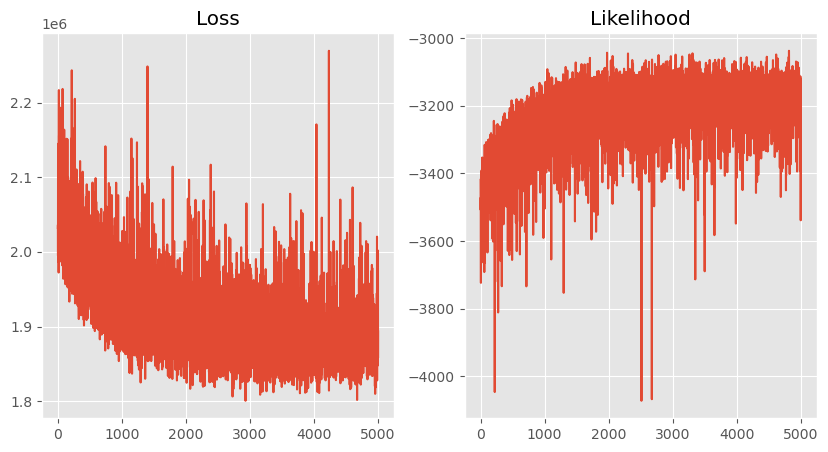

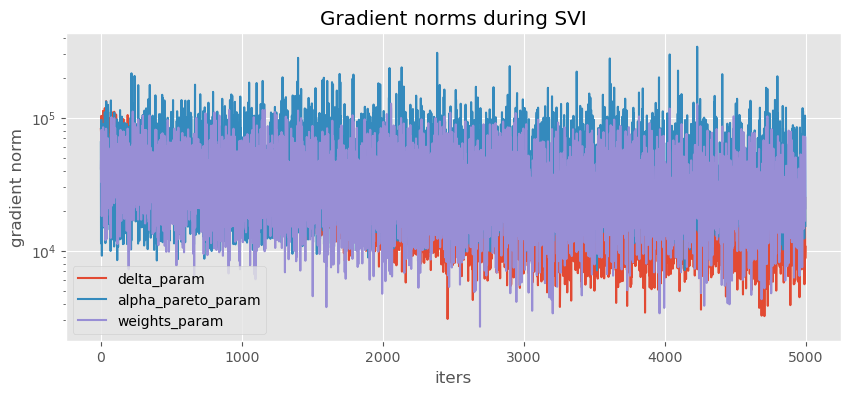

bic:  tensor(36376.5703, grad_fn=<RsubBackward1>)


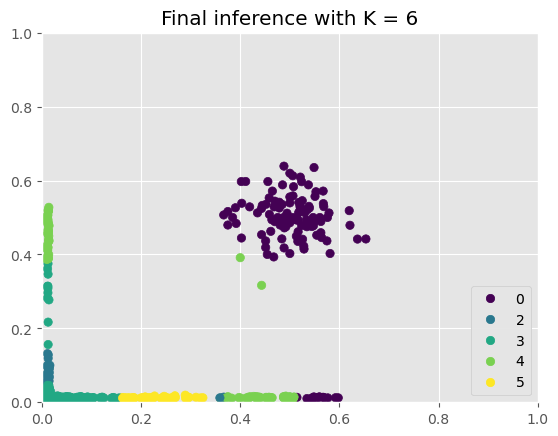

Selected number of clusters is 5 with seed 41


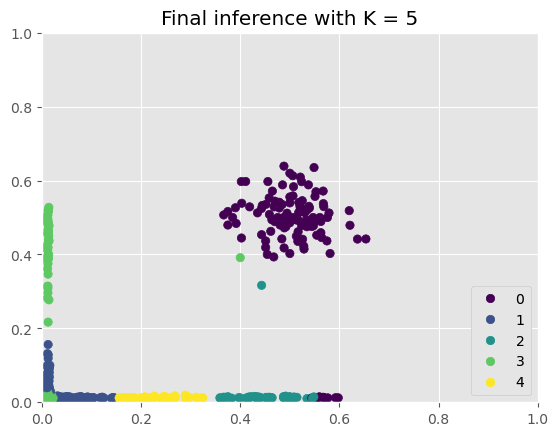

In [8]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 5000, K = [5,6], seed = [40,41,42], lr = 0.001)

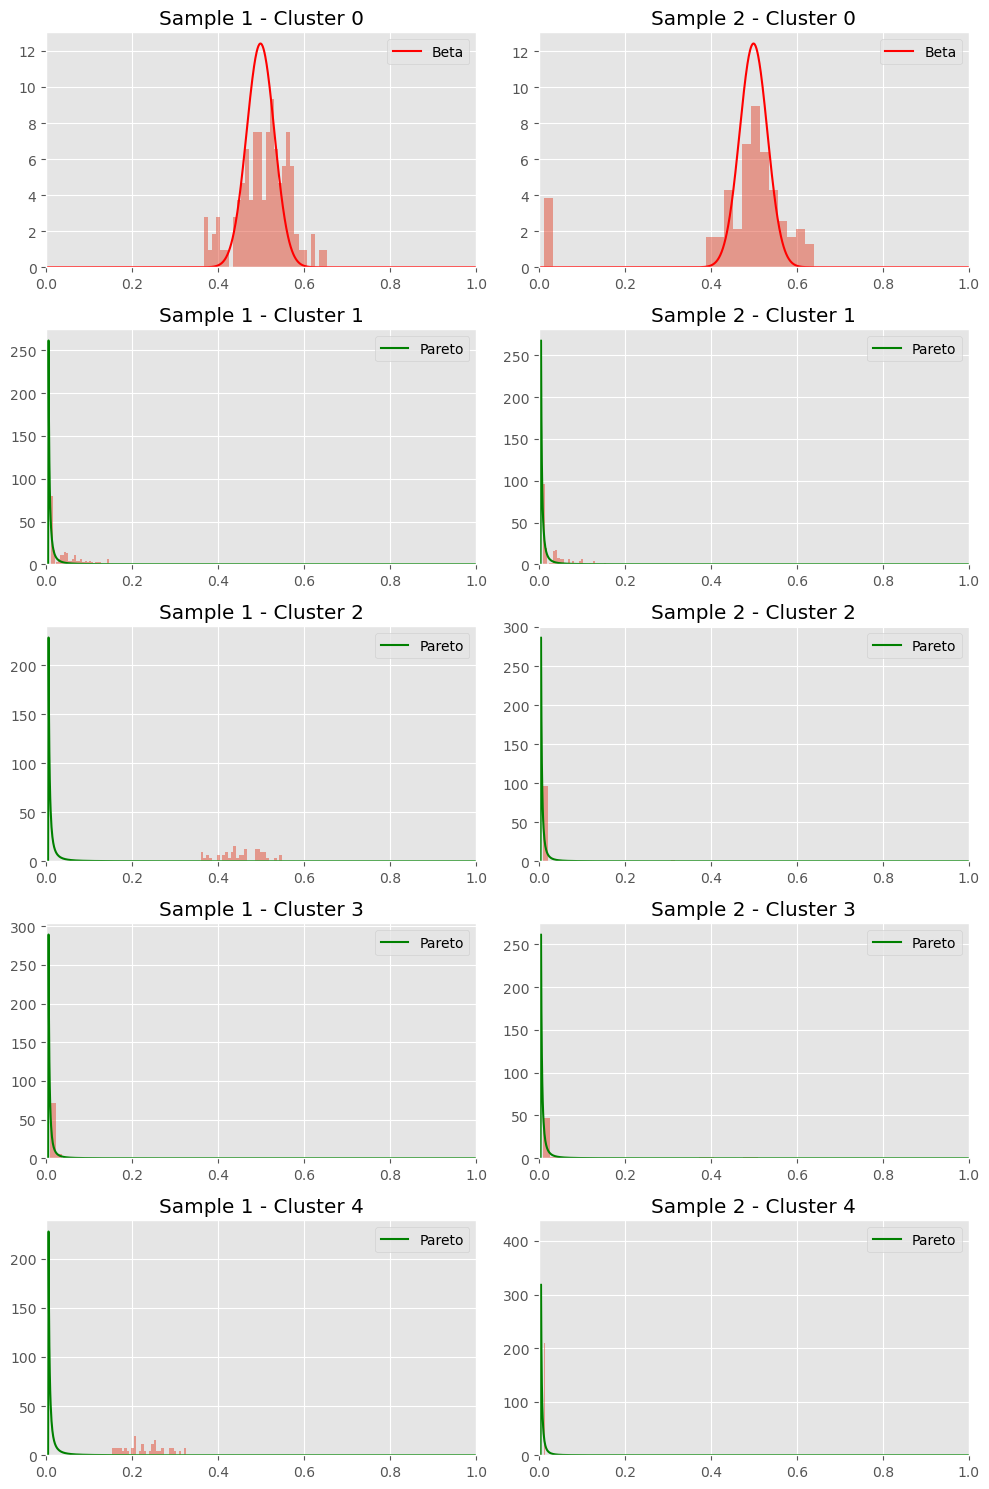

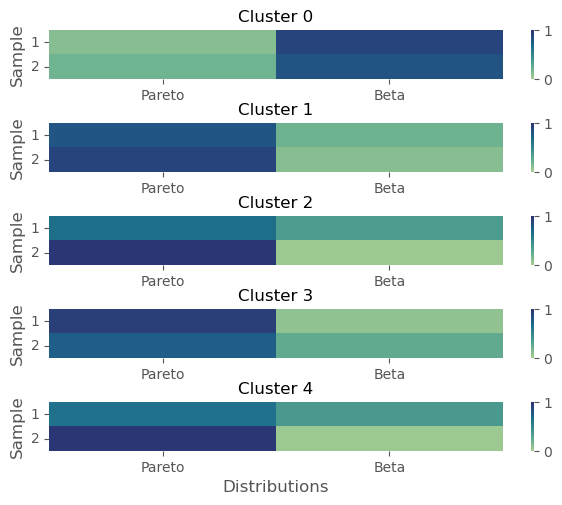

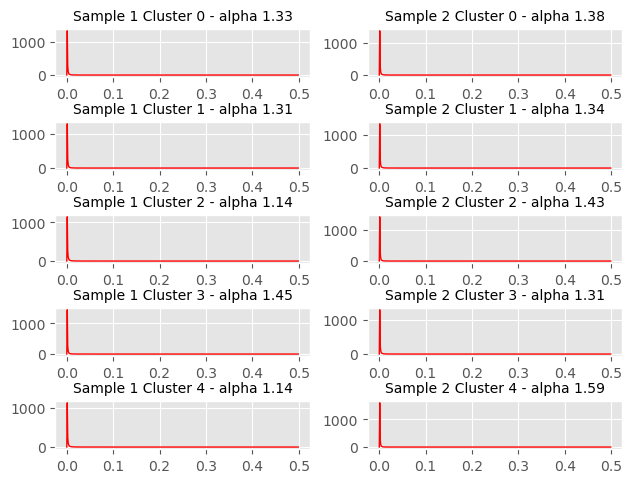

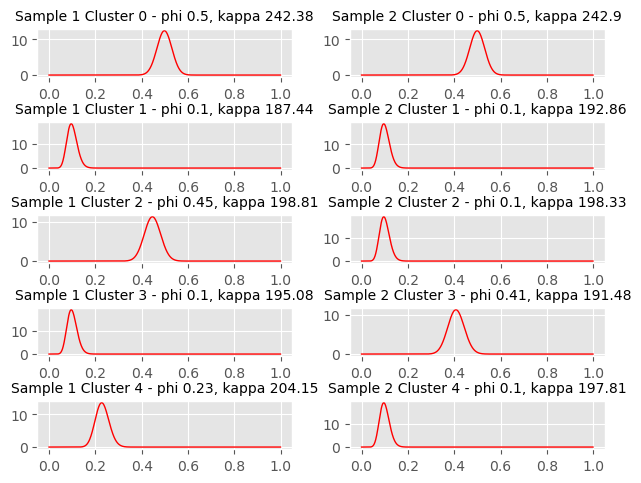

In [9]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

torch.Size([254])
Min vaf tensor(0.0092)


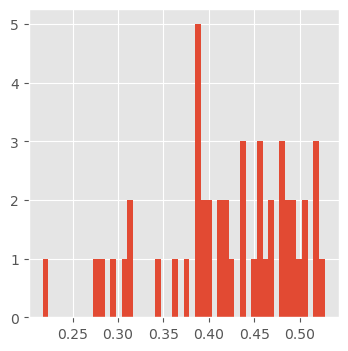

In [12]:
# CHECK LIKELIHOOD CLUSTER 4 SAMPLE 1
s = 2 # sample
k = 3 # cluster
d = s-1
labels = final_mb.params['cluster_assignments'].detach().numpy()
data_NV = NV[labels == k, d]
data_DP = DP[labels == k, d]
data_VAF = data_NV/data_DP
threshold = 0.2
data_VAF1 = data_VAF[data_VAF > threshold] # to check likelihood of data which are greater than 0.1
data_NV1 = data_NV[data_VAF > threshold] # i.e. what happens if data < 0.1 were assigned to a pareto in cluster 1
data_DP1 = data_DP[data_VAF > threshold]
print(data_VAF.shape)
plt.figure(figsize=(4, 4))
plt.hist(data_VAF1.numpy(), bins = 50);
# plt.ylim([0,60])
print("Min vaf", torch.min(data_VAF))
# plt.hist(data_VAF.numpy(), bins = 50);
# plt.xlim([0,1])
# x = np.linspace(0.001, 1., 100)
# phi_beta = final_mb.params["phi_beta_param"][k,d].detach()
# kappa_beta = final_mb.params["k_beta_param"][k,d].detach()
# a = phi_beta[k,d] * kappa_beta[k,d]
# b = (1-phi_beta[k,d]) * kappa_beta[k,d]
# pdf = beta.pdf(x, a, b)# * weights[k]
# plt.plot(x, pdf, linewidth=1.5, label='Beta', color='r')
# plt.legend()
# plt.plot(x, pdf, linewidth=1.5, label='Pareto', color='g')
# plt.legend()

In [125]:
labels = final_mb.params['cluster_assignments'].detach().numpy()
data_NV = NV[labels == k, ]
data_DP = DP[labels == k, ]
data_VAF = data_NV/data_DP

In [101]:
vaf.numpy().shape

(593, 2)

In [108]:
labels.shape

(593,)

In [112]:
(labels==k).shape
(np.where(vaf.numpy() > threshold, )[0]).shape

(346,)

In [124]:
vaf = NV/DP

idxs = (vaf.numpy() > threshold)[:,1] & (labels==k)

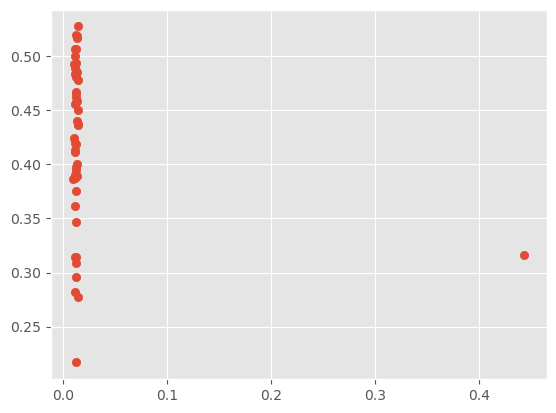

In [126]:
plt.scatter(vaf[idxs,0], vaf[idxs,1])

In [9]:
sns.heatmap(final_mb.params["responsib"][:,idxs].detach().numpy(), vmin=0, vmax=1, cmap="crest")

NameError: name 'idxs' is not defined

In [51]:
data_VAF = data_VAF1
data_NV = data_NV1
data_DP = data_DP1
phi_beta = final_mb.params["phi_beta_param"][k,d].detach()
print("Phi: ", phi_beta)
kappa_beta = final_mb.params["k_beta_param"][k,d].detach()
print("Kappa: ", kappa_beta)
alpha = (final_mb.params["alpha_pareto_param"][k,d]).detach() 
# alpha = torch.tensor(4.)
print("Alpha: ", alpha)
alpha = final_mb.alpha_factor*alpha
a_beta = phi_beta * kappa_beta
b_beta = (1-phi_beta) * kappa_beta
beta_log = dist.Beta(a_beta, b_beta).log_prob(data_VAF)
print("Beta log_prob", beta_log)
pareto_log = BoundedPareto(final_mb.pareto_L, alpha, final_mb.pareto_H).log_prob(data_VAF)
print("Pareto log_prob", pareto_log)

beta_lk_value = beta_lk(data_NV, data_DP, a_beta, b_beta)
print("BetaBin lk: ", beta_lk_value.sum())
pareto_lk_value = pareto_lk(data_NV, data_DP, alpha) # return a tensor of shape data_NV.shape[0]
print("ParetoBin lk: ", pareto_lk_value.sum())

Phi:  tensor(0.4209)
Kappa:  tensor(199.7862)
Alpha:  tensor(1.5799)
Beta log_prob tensor([  2.0759,   1.5875,   2.1696,   2.0321,  -0.0999,   1.8350,  -1.2493,
          2.0764,   2.0321,   1.1097,  -1.4063,   1.6025,   2.2685,   1.8652,
          0.7224,  -4.3840,   0.2751,   2.4336,  -0.5269,   1.9276,  -6.8619,
          1.9951,   2.2678,   2.4158,   0.9723,   0.3145,  -1.4817,   0.1442,
          0.9578,   1.9722,  -2.4885,  -2.1366,   1.7101,   2.3308,  -6.1797,
          2.4061,   0.5404,   2.4263,   0.8346,   1.5691,  -0.5269,   2.2261,
          2.3129,  -2.4885,   2.4345, -18.0504,  -3.0219])
Pareto log_prob tensor([ -9.4908,  -9.3209,  -9.5343,  -9.4722, -10.5177, -10.1601, -10.6526,
        -10.0794,  -9.4722, -10.3285, -10.6689, -10.2225,  -9.5894, -10.1511,
        -10.3971,  -8.3410, -10.4660,  -9.7785, -10.5713, -10.1317,  -8.0625,
         -9.4573,  -9.9904,  -9.7258,  -9.1639, -10.4603, -10.6766,  -8.9941,
        -10.3566,  -9.4484,  -8.5818, -10.7402, -10.1950,  -9.

torch.Size([441])
torch.Size([441])


(0.0, 1.0)

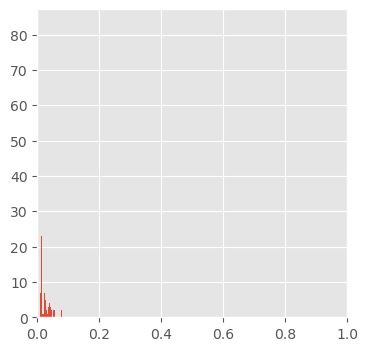

In [122]:
# CHECK LIKELIHOOD CLUSTER 1 SAMPLE 1, taking also some of the points assigned to cluster 4
s = 1 # sample
k = 1 # cluster
d = s-1
labels = final_mb.params['cluster_assignments'].detach().numpy()
data_NV = NV[:,d] + 1e-5
data_DP = DP[:,d]
data_VAF = data_NV/data_DP
threshold = 0.1
data_VAF1 = data_VAF[data_VAF <= threshold]
data_NV1 = data_NV[data_VAF <= threshold]
data_DP1 = data_DP[data_VAF <= threshold]
print(data_VAF.shape)
plt.figure(figsize=(4, 4))
plt.hist(data_VAF1.numpy(), bins = 50);
plt.xlim([0,1])
# plt.hist(data_VAF.numpy(), bins = 50);
# plt.xlim([0,1])

In [123]:
data_VAF = data_VAF1
data_NV = data_NV1
data_DP = data_DP1
phi_beta = final_mb.params["phi_beta_param"][k,d].detach()
print("Phi: ", phi_beta)
kappa_beta = final_mb.params["k_beta_param"][k,d].detach()
print("Kappa: ", kappa_beta)
alpha = (final_mb.params["alpha_pareto_param"][k,d]).detach() 
# alpha = torch.tensor(4.)
print("Alpha: ", alpha)
alpha = final_mb.alpha_factor*alpha
a_beta = phi_beta * kappa_beta
b_beta = (1-phi_beta) * kappa_beta
# beta_log = dist.Beta(a_beta, b_beta).log_prob(data_VAF)
# print("Beta log_prob", beta_log)
# pareto_log = BoundedPareto(final_mb.pareto_L, alpha, final_mb.pareto_H).log_prob(data_VAF)
# print("Pareto log_prob", pareto_log)

beta_lk_value = beta_lk(data_NV, data_DP, a_beta, b_beta)
print("BetaBin lk: ", beta_lk_value.sum())
pareto_lk_value = pareto_lk(data_NV, data_DP, alpha) # return a tensor of shape data_NV.shape[0]
print("ParetoBin lk: ", pareto_lk_value.sum())

Phi:  tensor(0.0381)
Kappa:  tensor(199.1076)
Alpha:  tensor(1.2539)
BetaBin lk:  tensor(-476.1728)
ParetoBin lk:  tensor(-819.5447)


In [10]:
final_mb.params

{'weights_param': tensor([0.2452, 0.1827, 0.1659, 0.2240, 0.1823], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.3277, 1.3818],
         [1.3077, 1.3396],
         [1.1424, 1.4325],
         [1.4468, 1.3067],
         [1.1378, 1.5924]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.4979, 0.4991],
         [0.1000, 0.1000],
         [0.4466, 0.1000],
         [0.1000, 0.4083],
         [0.2299, 0.1000]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[242.3779, 242.8953],
         [187.4408, 192.8636],
         [198.8141, 198.3301],
         [195.0835, 191.4763],
         [204.1537, 197.8145]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.1104, 0.8896],
          [0.1922, 0.8078]],
 
         [[0.8024, 0.1976],
          [0.8884, 0.1116]],
 
         [[0.6490, 0.3510],
          [0.9673, 0.0327]],
 
         [[0.9243, 0.0757],
          [0.7485, 0.2515]],
 
         [[0.6315, 0.3685],
          [0.9652, 0.0348]]], grad_fn=<DivBackward0>),
 'responsib': t

### rRACES longitudinal data

In [14]:
NV_r = pd.read_csv("./rRACES_data/NV_long.csv")
DP_r = pd.read_csv("./rRACES_data/DP_long.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([1224, 2])
torch.Size([1224, 2])


In [17]:
torch.sum((NV[:,0]/DP[:,0] < 0.15) & (NV[:,0]/DP[:,0] > 0.))

tensor(424)

In [4]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0094)
tensor(0.0095)


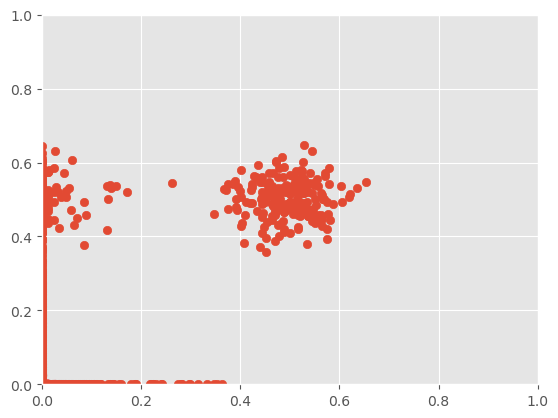

In [5]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

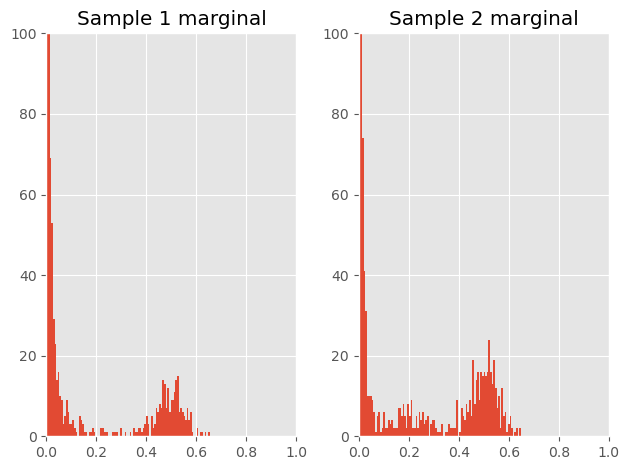

In [6]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 100)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 100)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[1.4442e-02, 1.1785e-02],
        [4.9358e-01, 5.0280e-01],
        [1.6109e-02, 4.9525e-01],
        [2.2913e-01, 1.4901e-08],
        [1.4901e-08, 2.1557e-01]])


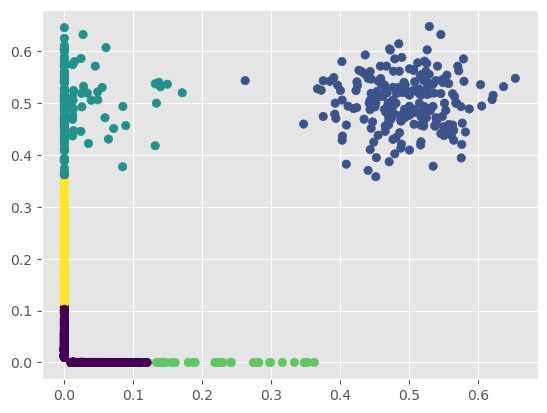

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

RUN WITH K = 5 AND SEED = 40
NV = 0 before: tensor(965)
NV = 0 after: tensor(0)
Iteration 0: Loss = 8800734.0
Iteration 200: Loss = 8612353.0
Iteration 400: Loss = 8510795.0
Iteration 600: Loss = 8257996.5
Iteration 800: Loss = 8887132.0
Iteration 1000: Loss = 8302189.5
Iteration 1200: Loss = 8073070.5
Iteration 1400: Loss = 7996798.5
Iteration 1600: Loss = 7915217.0
Iteration 1800: Loss = 8384703.0
Iteration 2000: Loss = 8110897.0
Iteration 2200: Loss = 8251361.5
Iteration 2400: Loss = 7778028.5
Iteration 2600: Loss = 7727813.0
Iteration 2800: Loss = 7703154.0
Iteration 3000: Loss = 8317569.5
Iteration 3200: Loss = 8261329.0
Iteration 3400: Loss = 7985317.0
Iteration 3600: Loss = 7936828.0
Iteration 3800: Loss = 7945460.0
Iteration 4000: Loss = 8265110.0
Iteration 4200: Loss = 8189830.5
Iteration 4400: Loss = 7660120.0
Iteration 4600: Loss = 7845197.0
Iteration 4800: Loss = 7913356.0
Iteration 5000: Loss = 7940487.0
Iteration 5200: Loss = 7786828.0
Iteration 5400: Loss = 7630233.0
Ite

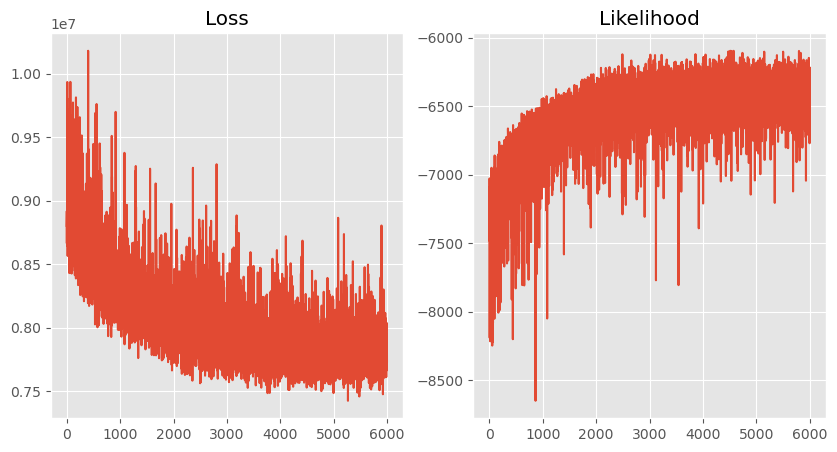

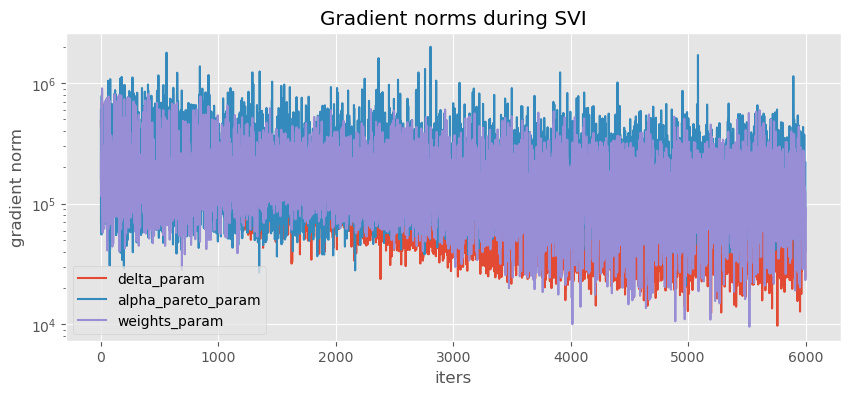

bic:  tensor(72077.1953, grad_fn=<RsubBackward1>)


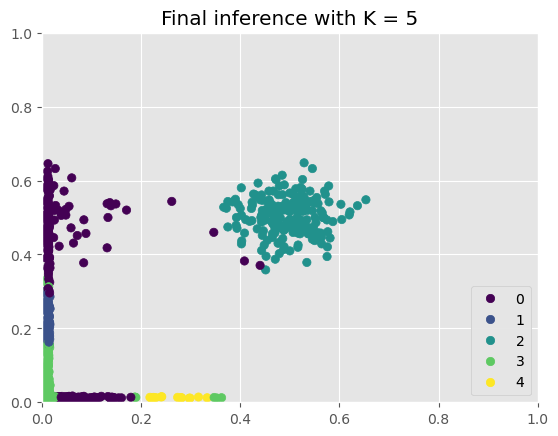

RUN WITH K = 5 AND SEED = 41
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
Iteration 0: Loss = 9106561.0
Iteration 200: Loss = 9369993.0
Iteration 400: Loss = 8247361.0
Iteration 600: Loss = 8293670.0
Iteration 800: Loss = 8480065.0
Iteration 1000: Loss = 8051859.0
Iteration 1200: Loss = 8330526.0
Iteration 1400: Loss = 7784444.0
Iteration 1600: Loss = 7964592.0
Iteration 1800: Loss = 7795974.0
Iteration 2000: Loss = 7654280.0
Iteration 2200: Loss = 7644221.0
Iteration 2400: Loss = 7756014.5
Iteration 2600: Loss = 7800900.5
Iteration 2800: Loss = 7937307.5
Iteration 3000: Loss = 7950025.0
Iteration 3200: Loss = 7773597.5
Iteration 3400: Loss = 8176087.5
Iteration 3600: Loss = 7892160.0
Iteration 3800: Loss = 7794601.0
Iteration 4000: Loss = 7833999.5
Iteration 4200: Loss = 7838169.0
Iteration 4400: Loss = 7905861.0
Iteration 4600: Loss = 7874333.0
Iteration 4800: Loss = 8063456.0
Iteration 5000: Loss = 7735801.5
Iteration 5200: Loss = 7738331.5
Iteration 5400: Loss = 7909206.0
Itera

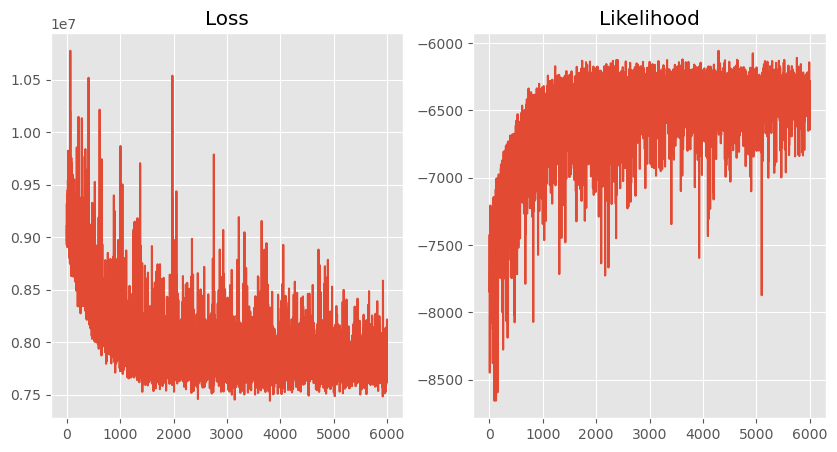

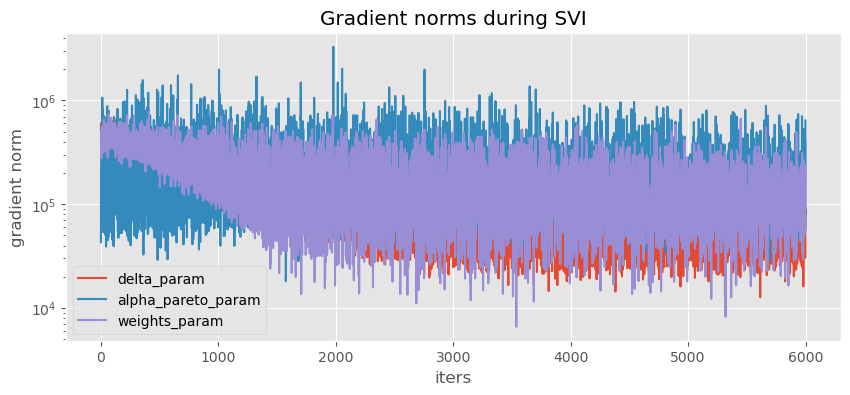

bic:  tensor(72086.2812, grad_fn=<RsubBackward1>)


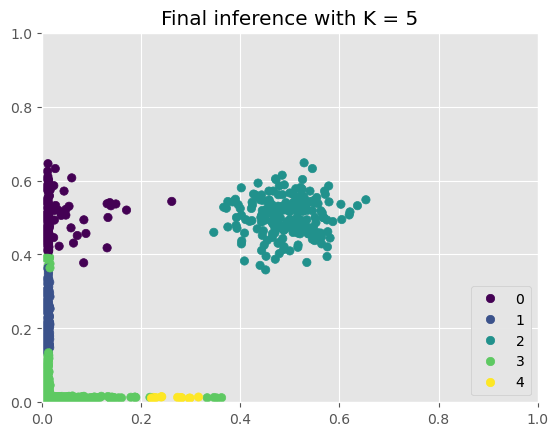

RUN WITH K = 5 AND SEED = 42
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
Iteration 0: Loss = 9101931.0
Iteration 200: Loss = 8802672.0
Iteration 400: Loss = 8459310.0
Iteration 600: Loss = 8179145.0
Iteration 800: Loss = 8176498.5
Iteration 1000: Loss = 9311161.0
Iteration 1200: Loss = 8052816.0
Iteration 1400: Loss = 7699435.5
Iteration 1600: Loss = 8078574.5
Iteration 1800: Loss = 7927265.0
Iteration 2000: Loss = 7569813.5
Iteration 2200: Loss = 8001429.0
Iteration 2400: Loss = 7913381.5
Iteration 2600: Loss = 7999410.5
Iteration 2800: Loss = 7912088.0
Iteration 3000: Loss = 8435980.0
Iteration 3200: Loss = 7759213.5
Iteration 3400: Loss = 7883538.0
Iteration 3600: Loss = 7937180.5
Iteration 3800: Loss = 7851080.5
Iteration 4000: Loss = 7966986.0
Iteration 4200: Loss = 7746702.0
Iteration 4400: Loss = 8042624.0
Iteration 4600: Loss = 7840259.0
Iteration 4800: Loss = 7794383.0
Iteration 5000: Loss = 7831005.5
Iteration 5200: Loss = 7727182.0
Iteration 5400: Loss = 7671652.0
Itera

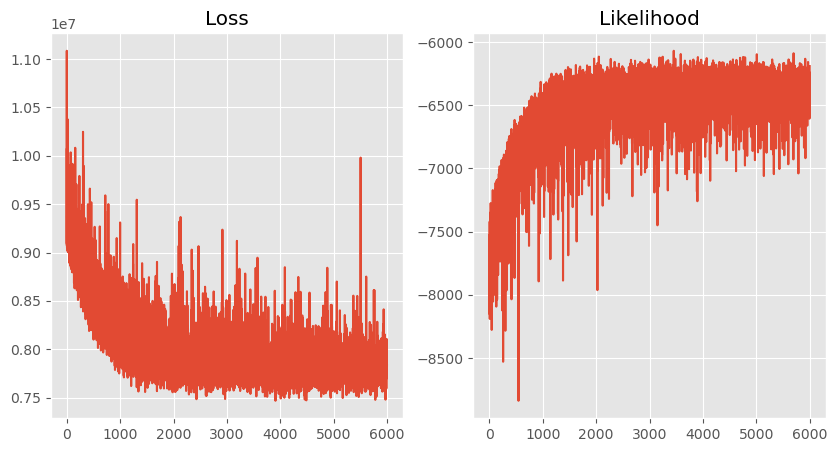

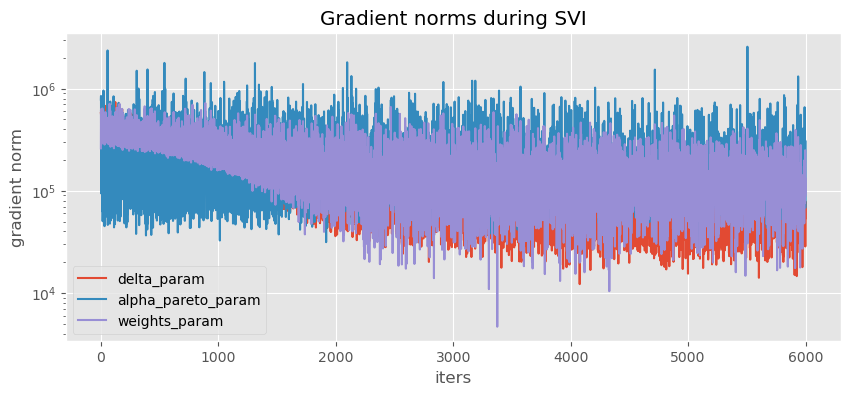

bic:  tensor(72079.0391, grad_fn=<RsubBackward1>)


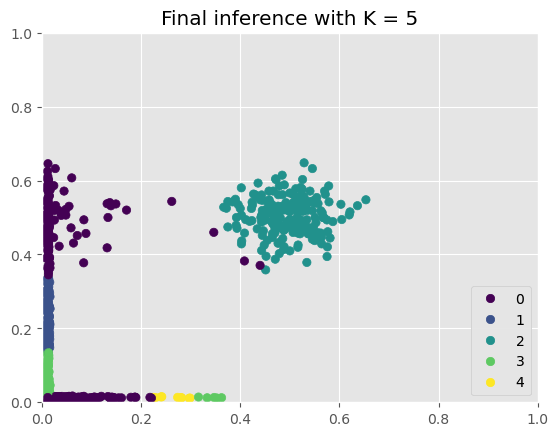

Selected number of clusters is 5 with seed 40


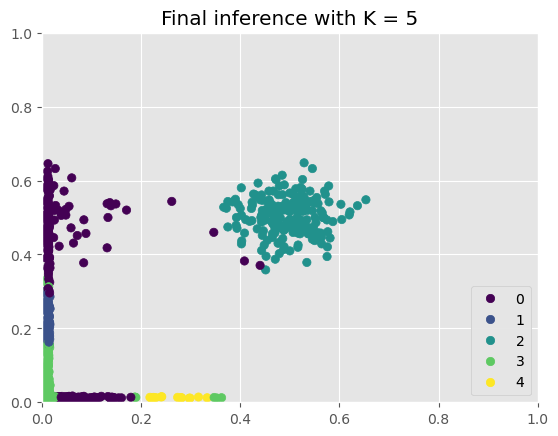

In [8]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 6000, K = [5], seed = [40,41,42], lr = 0.001)

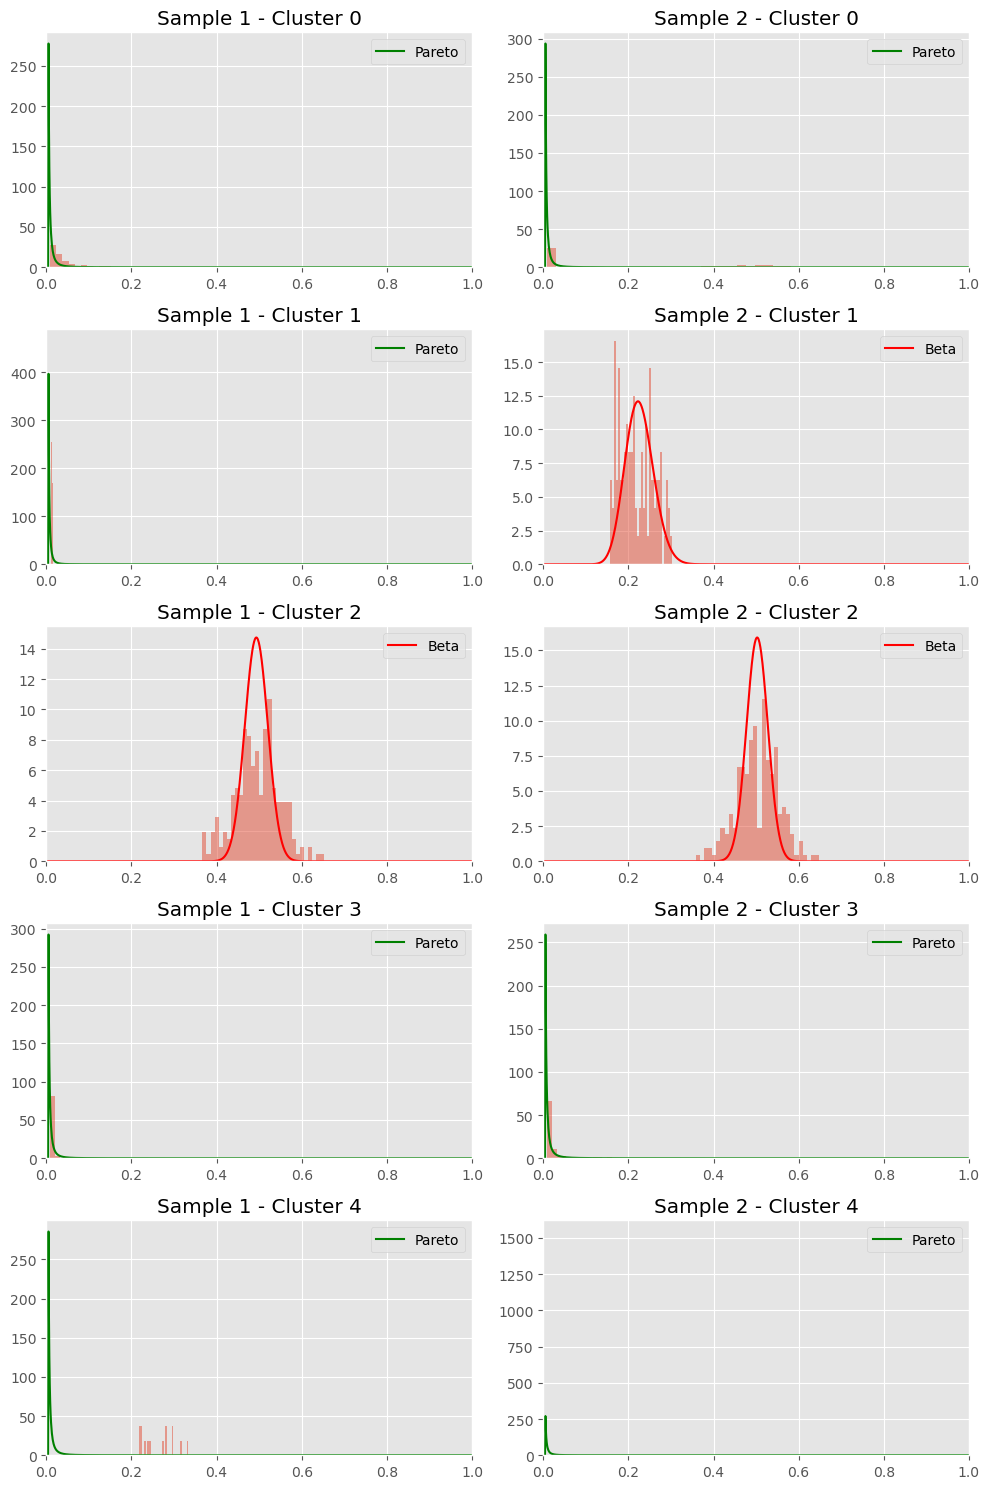

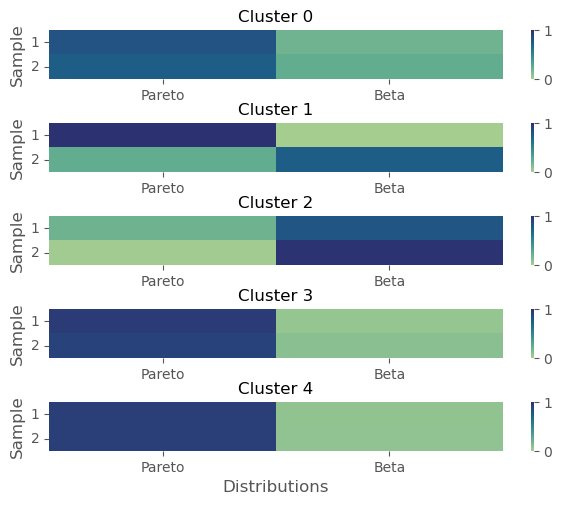

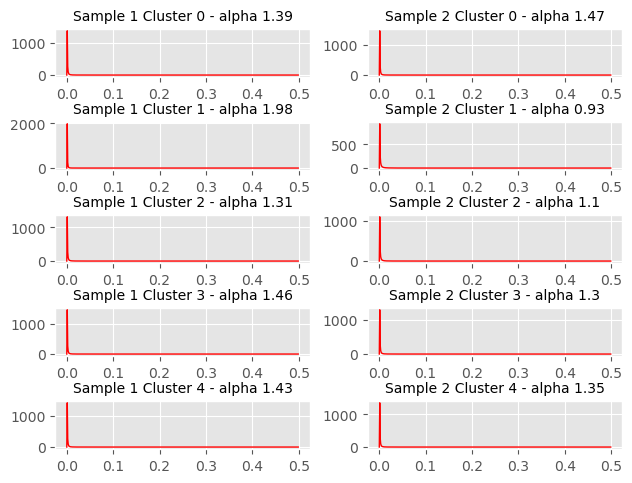

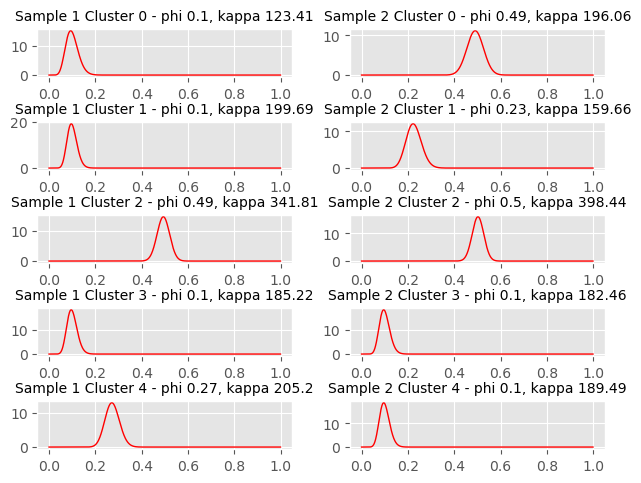

In [9]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [11]:
final_mb.params

{'weights_param': tensor([0.2569, 0.1290, 0.2239, 0.2081, 0.1820], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.3874, 1.4684],
         [1.9821, 0.9304],
         [1.3093, 1.0994],
         [1.4610, 1.2956],
         [1.4286, 1.3538]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.1000, 0.4905],
         [0.1000, 0.2259],
         [0.4934, 0.5025],
         [0.1000, 0.1000],
         [0.2732, 0.1000]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[123.4094, 196.0598],
         [199.6880, 159.6617],
         [341.8081, 398.4417],
         [185.2237, 182.4640],
         [205.1963, 189.4945]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.8098, 0.1902],
          [0.7574, 0.2426]],
 
         [[0.9963, 0.0037],
          [0.2438, 0.7562]],
 
         [[0.1988, 0.8012],
          [0.0118, 0.9882]],
 
         [[0.9430, 0.0570],
          [0.8985, 0.1015]],
 
         [[0.9260, 0.0740],
          [0.9234, 0.0766]]], grad_fn=<DivBackward0>),
 'responsib': t